In [22]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:

# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:

# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [8]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [9]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

In [11]:
loss_arr = []

====> Test set loss: 135.4848
====> Epoch: 1 Average loss: 132.4405
====> Test set loss: 115.8244
====> Epoch: 2 Average loss: 121.1647
====> Test set loss: 108.7965
====> Epoch: 3 Average loss: 116.1768
====> Test set loss: 104.6374
====> Epoch: 4 Average loss: 113.5122
====> Test set loss: 103.1882
====> Epoch: 5 Average loss: 111.8114
====> Test set loss: 101.3845
====> Epoch: 6 Average loss: 110.4896
====> Test set loss: 100.3638
====> Epoch: 7 Average loss: 109.5328
====> Test set loss: 99.8786
====> Epoch: 8 Average loss: 108.7570
====> Test set loss: 99.5388
====> Epoch: 9 Average loss: 108.0886
====> Test set loss: 98.5645
====> Epoch: 10 Average loss: 107.5872
====> Test set loss: 98.6514


<ipython-input-2-febedcb7ee00>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


====> Epoch: 11 Average loss: 107.1226
====> Test set loss: 97.7778
====> Epoch: 12 Average loss: 106.7836
====> Test set loss: 97.2081
====> Epoch: 13 Average loss: 106.4331
====> Test set loss: 96.9437
====> Epoch: 14 Average loss: 106.1429
====> Test set loss: 97.5950
====> Epoch: 15 Average loss: 105.8677
====> Test set loss: 96.6464
====> Epoch: 16 Average loss: 105.6855
====> Test set loss: 97.4922
====> Epoch: 17 Average loss: 105.4379
====> Test set loss: 96.6287
====> Epoch: 18 Average loss: 105.2140
====> Test set loss: 96.0719
====> Epoch: 19 Average loss: 105.0440
====> Test set loss: 95.9174
====> Epoch: 20 Average loss: 104.8778
====> Test set loss: 95.1068
====> Epoch: 21 Average loss: 104.7367
====> Test set loss: 96.4319
====> Epoch: 22 Average loss: 104.6189
====> Test set loss: 95.6213
====> Epoch: 23 Average loss: 104.4707
====> Test set loss: 95.9540
====> Epoch: 24 Average loss: 104.2921
====> Test set loss: 95.1011
====> Epoch: 25 Average loss: 104.1667
====> Tes

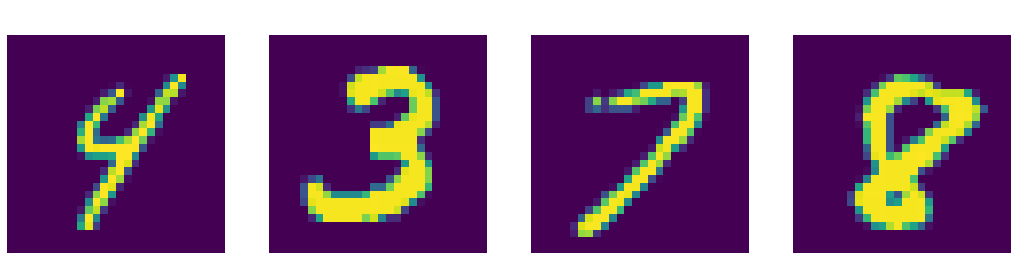

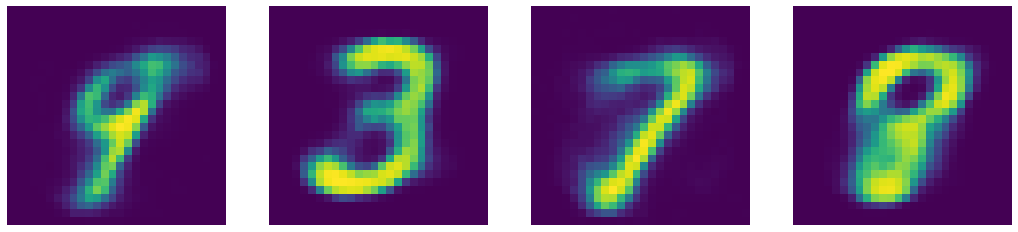

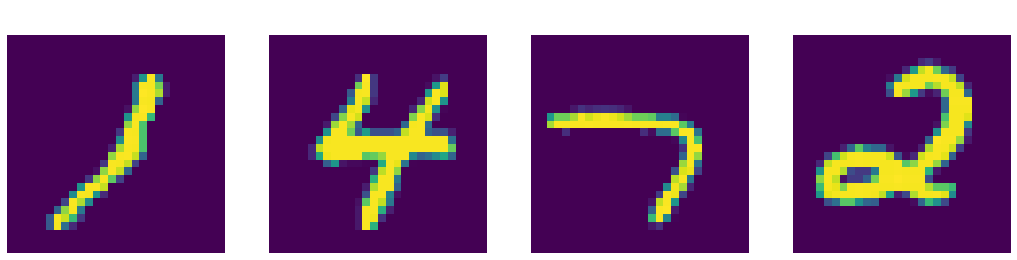

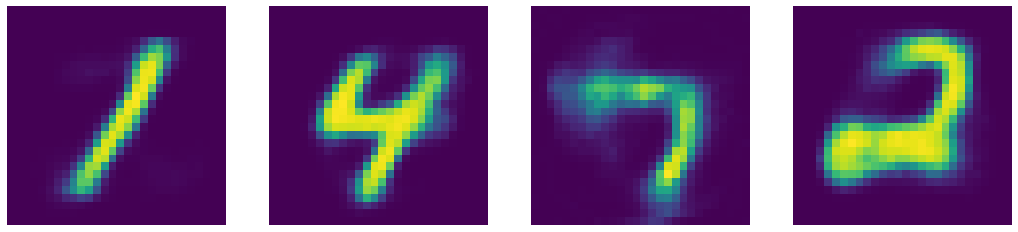

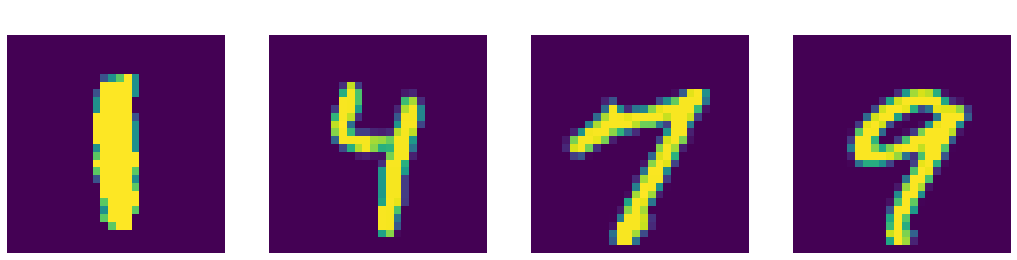

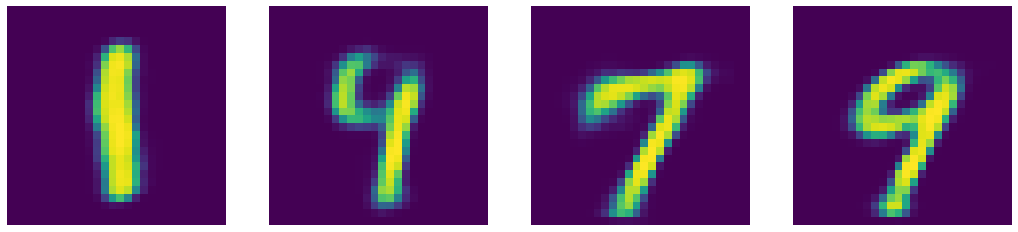

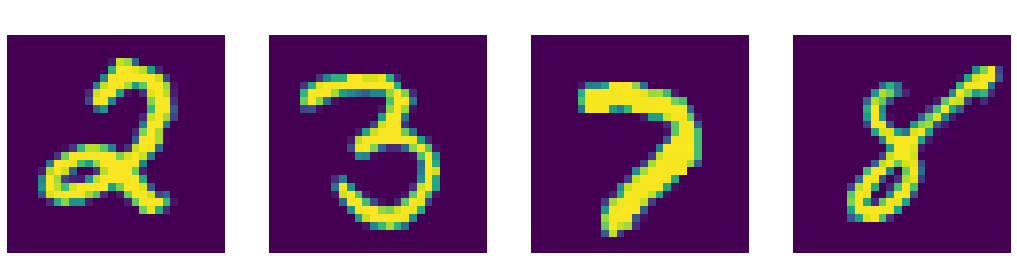

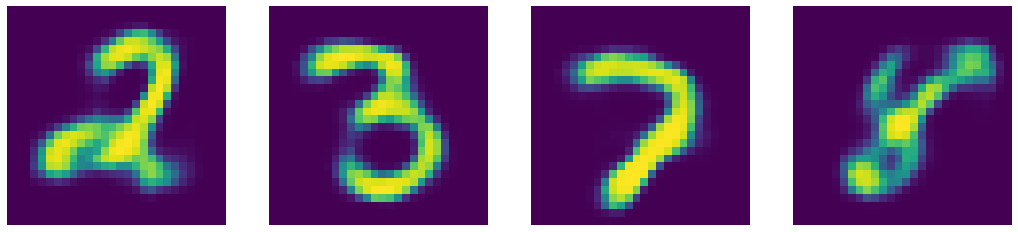

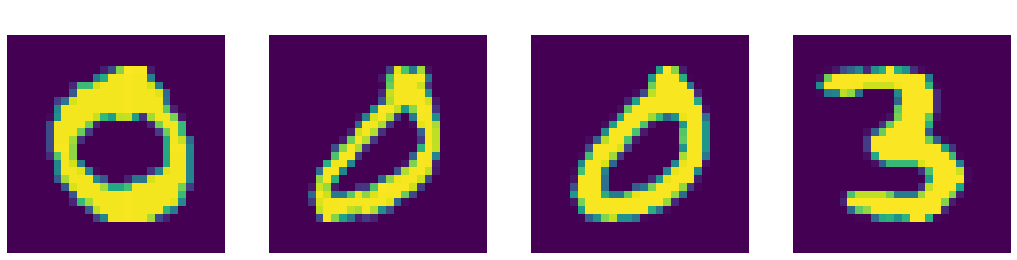

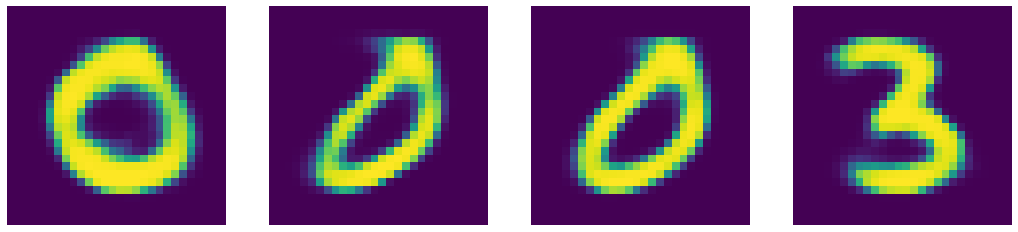

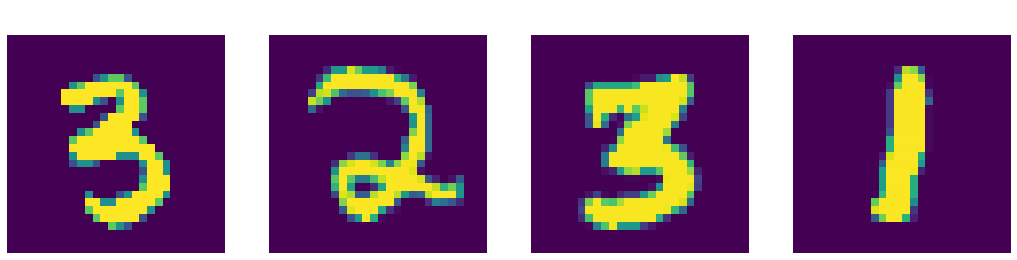

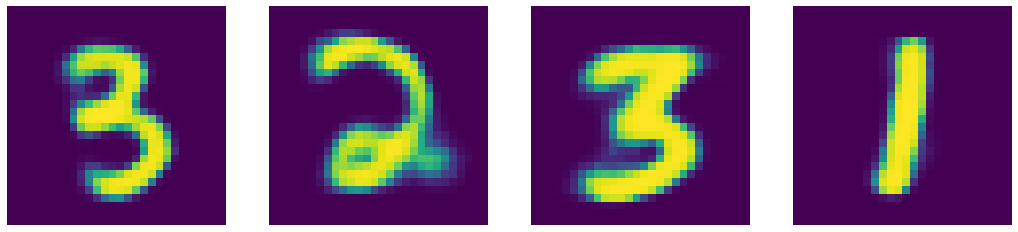

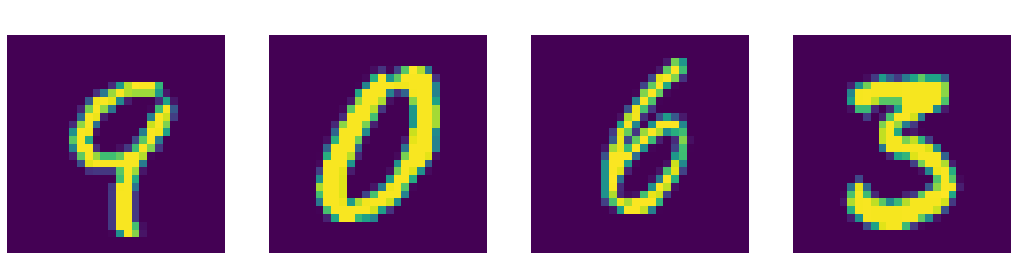

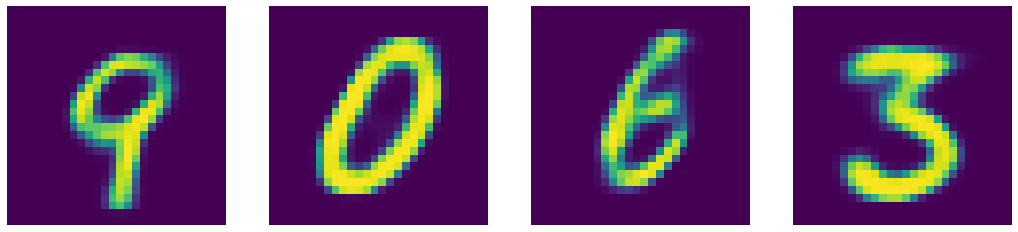

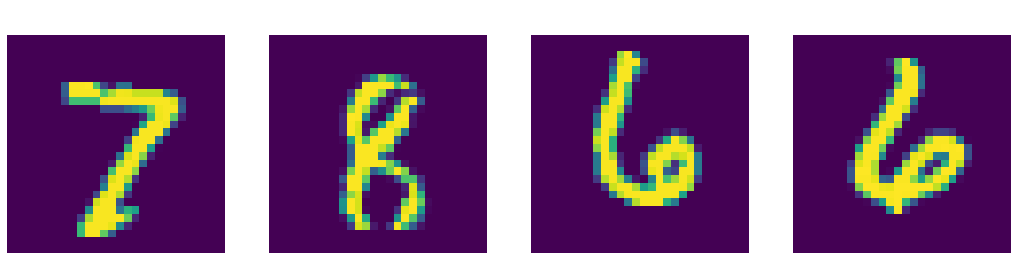

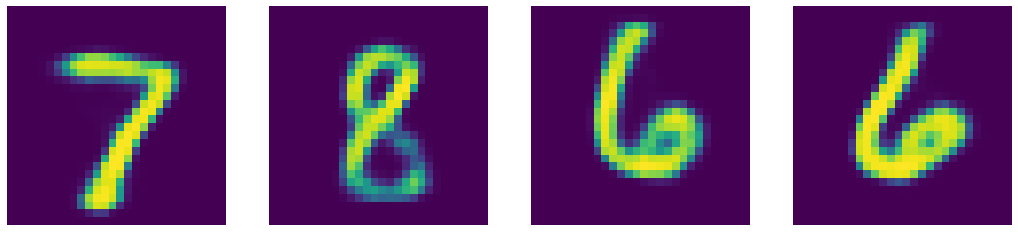

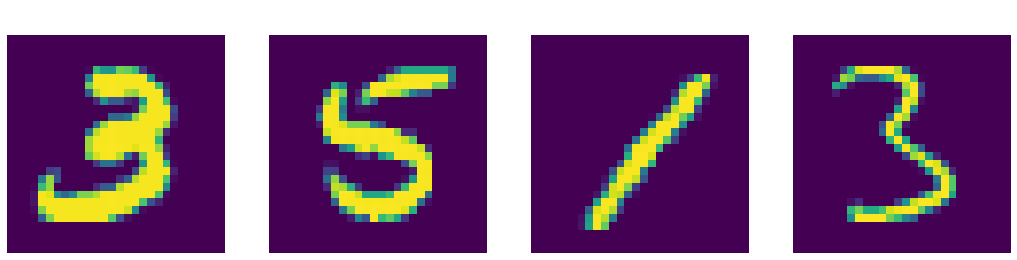

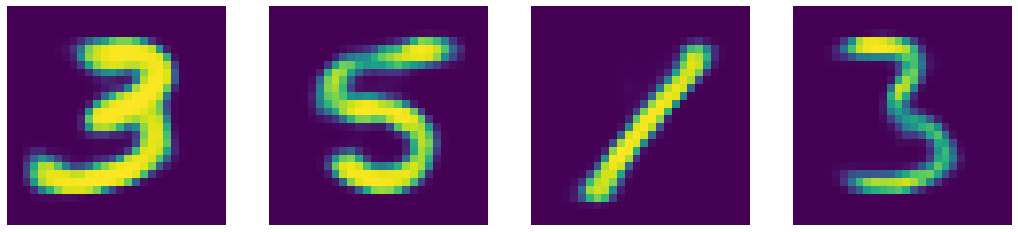

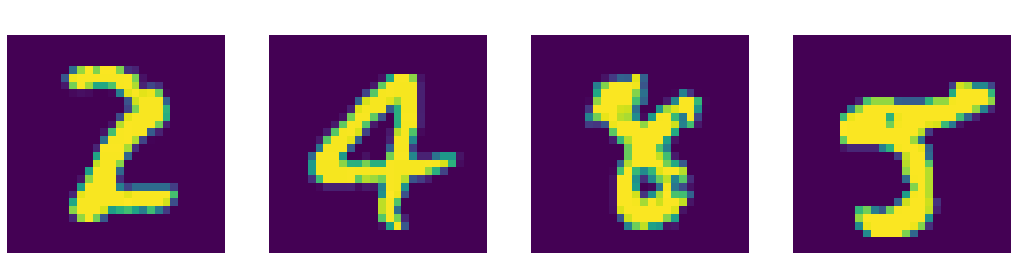

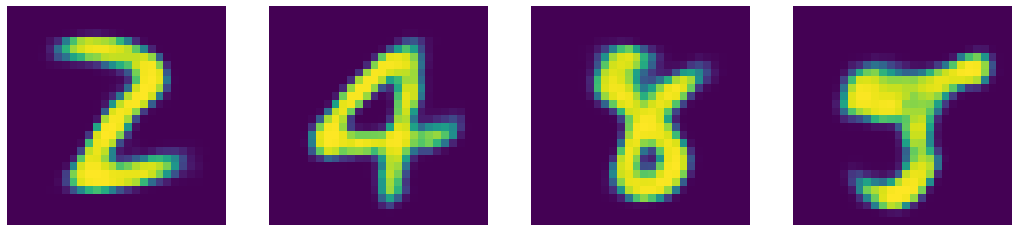

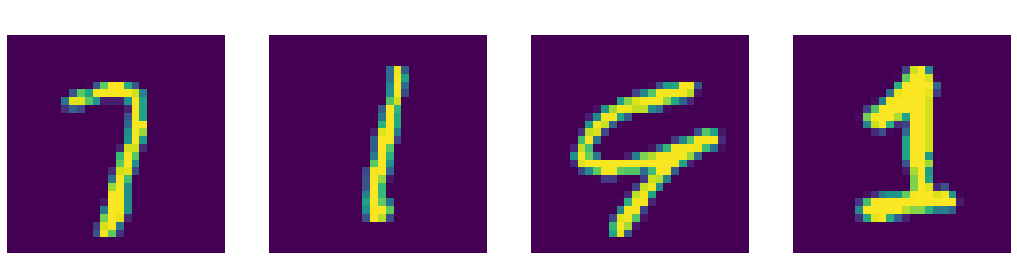

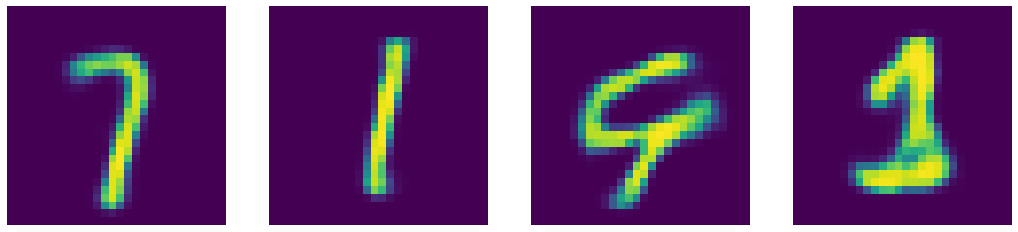

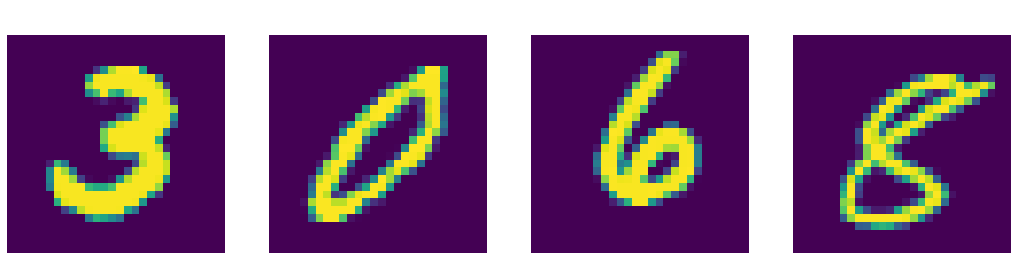

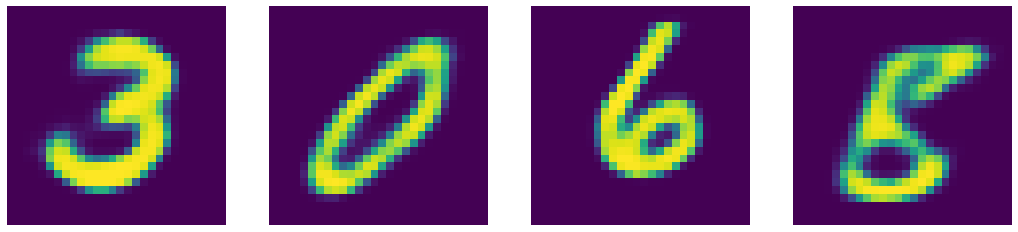

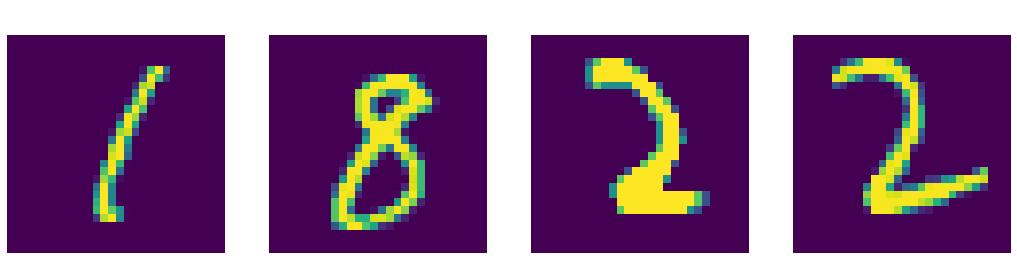

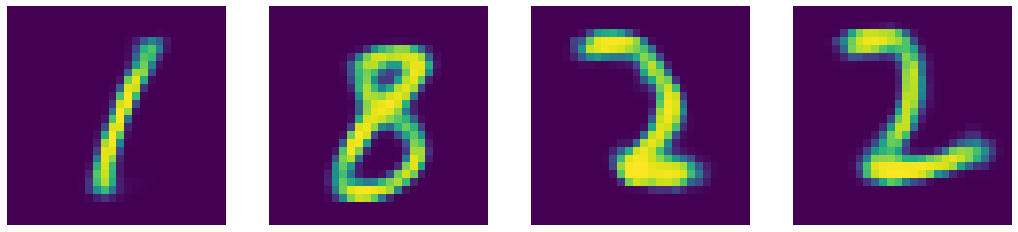

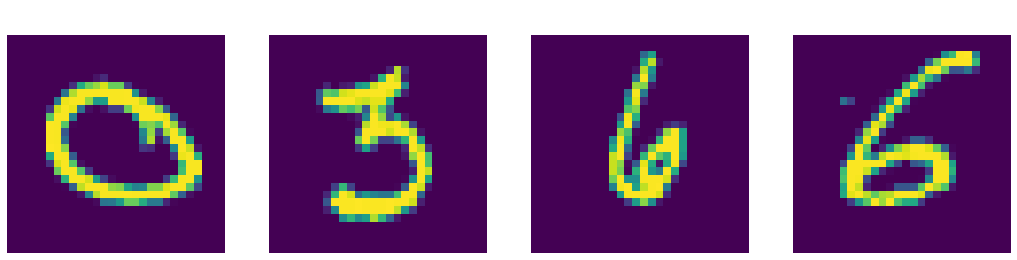

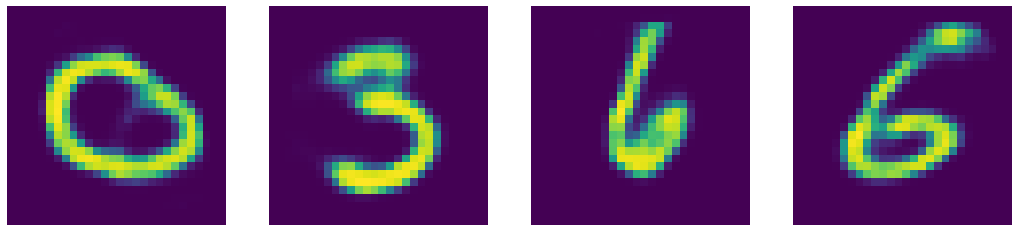

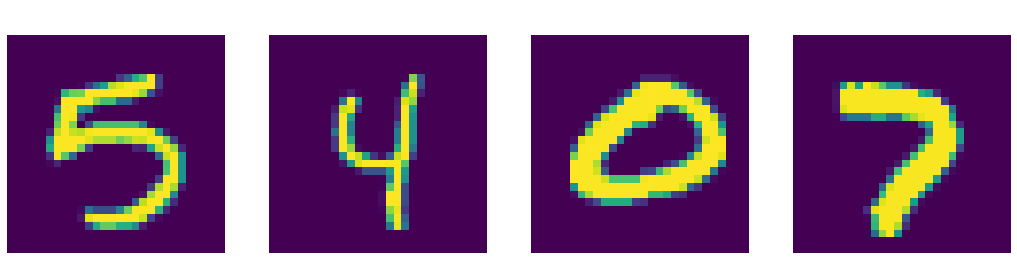

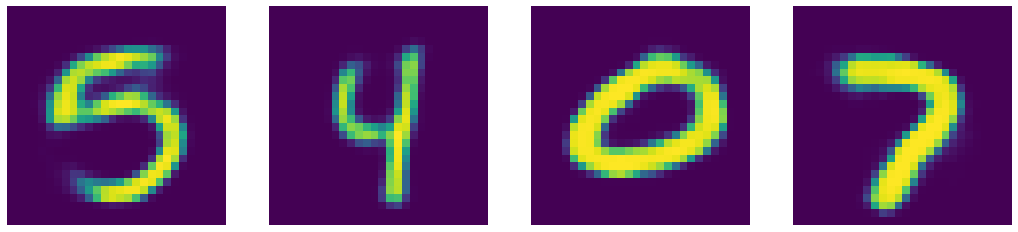

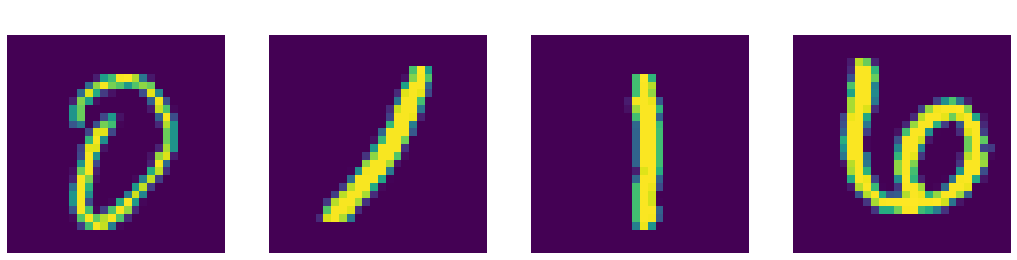

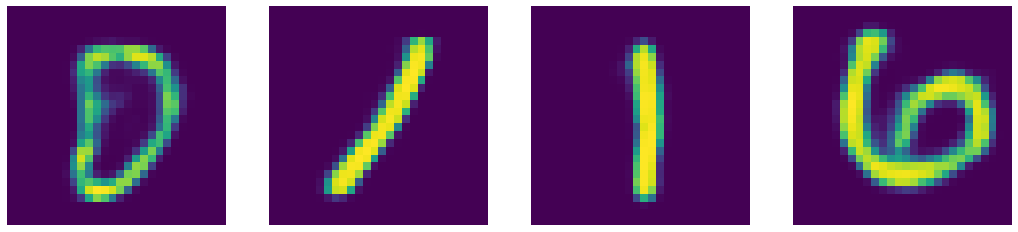

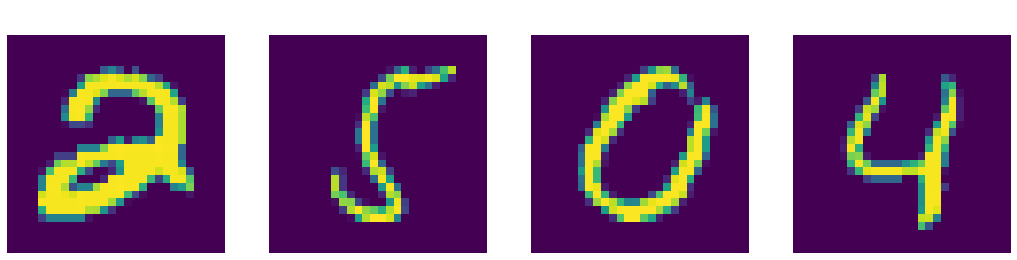

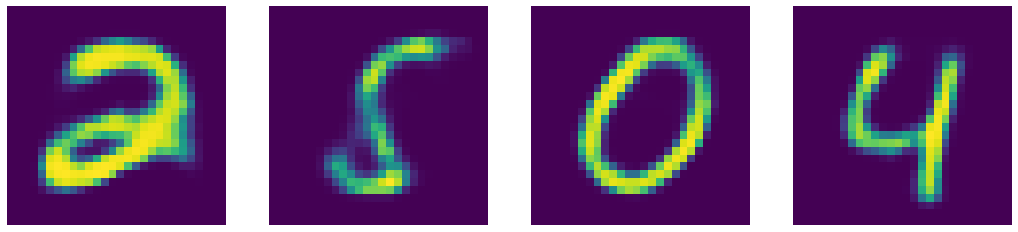

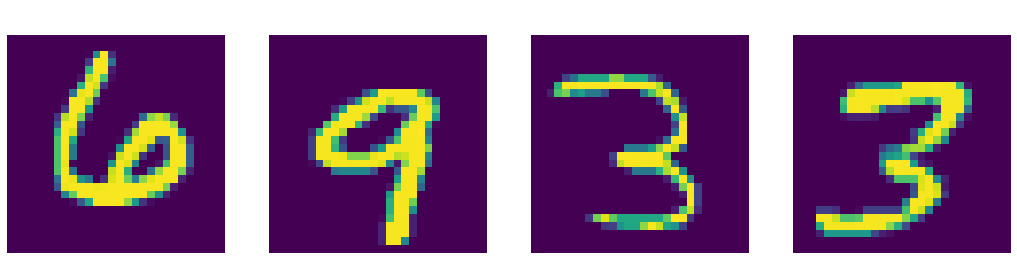

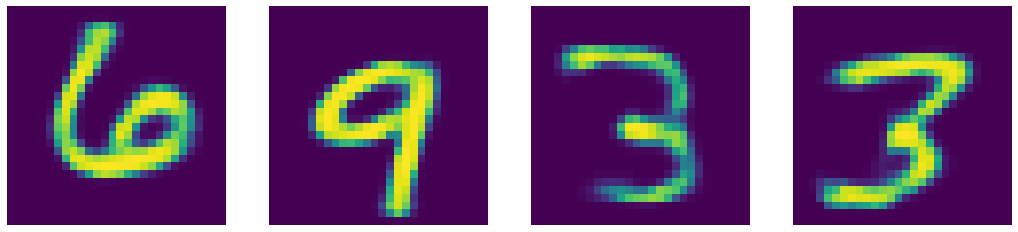

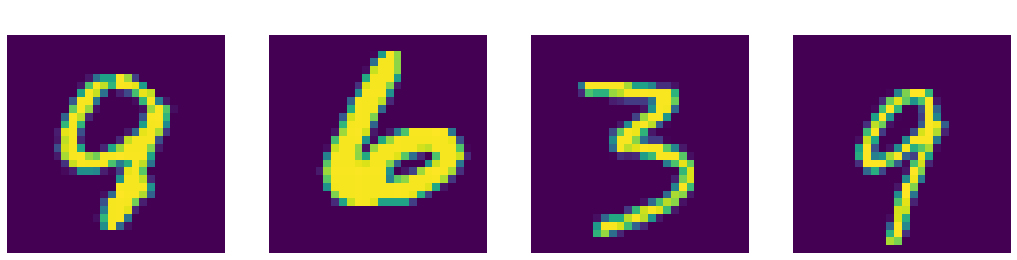

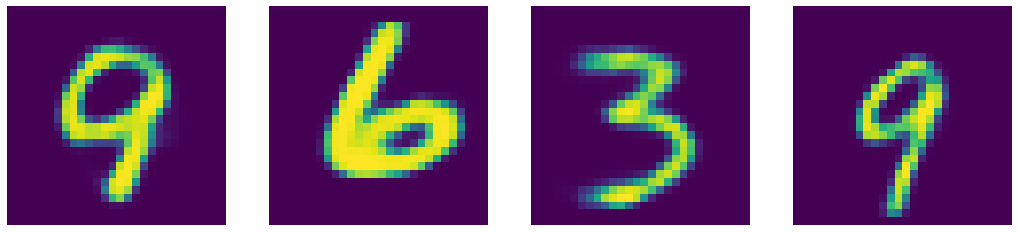

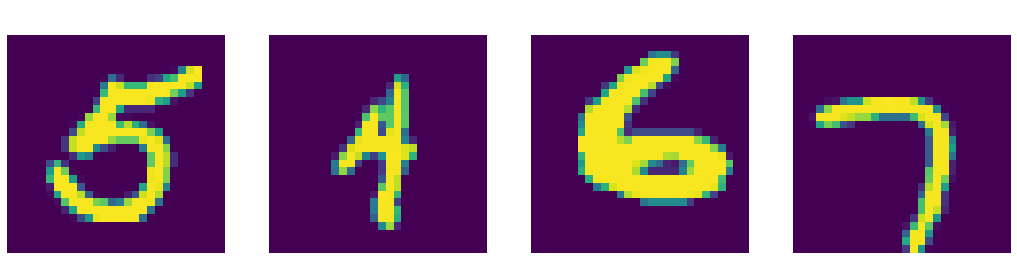

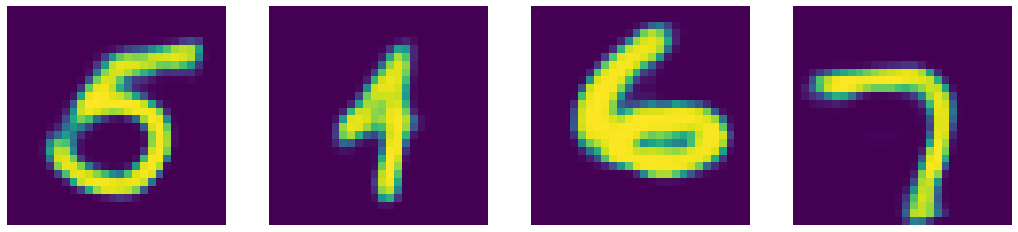

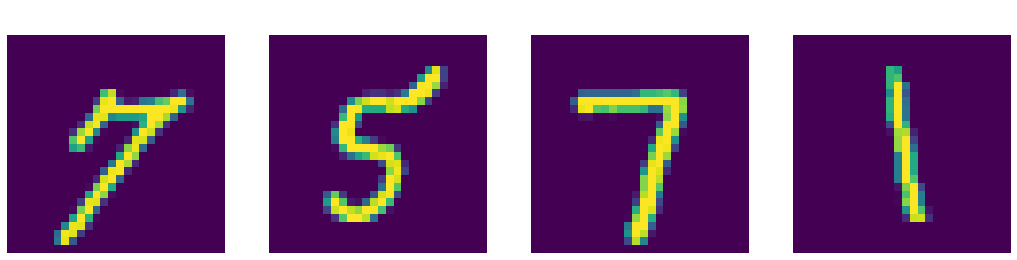

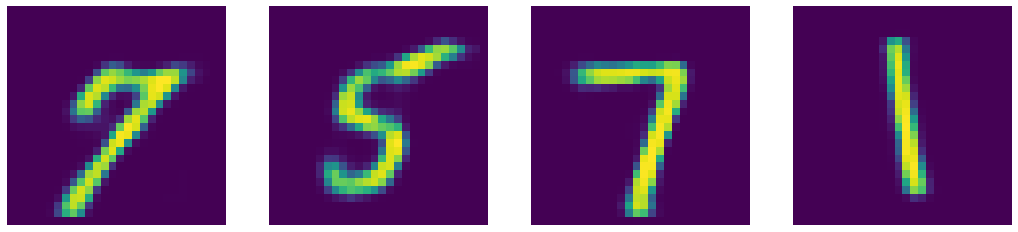

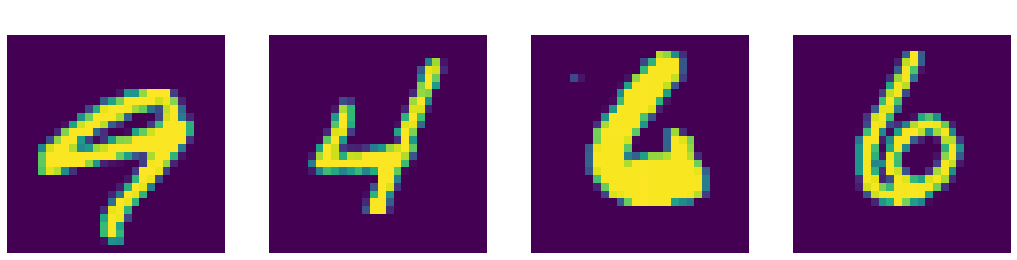

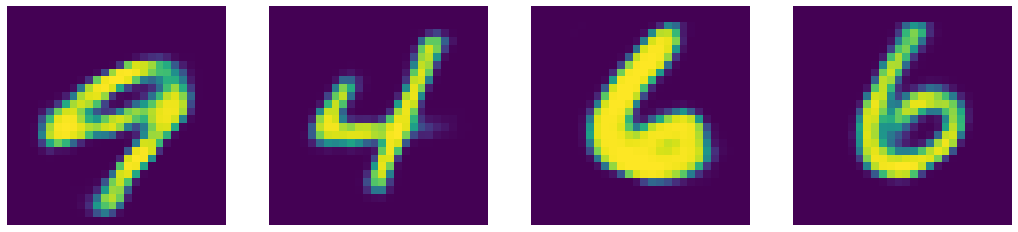

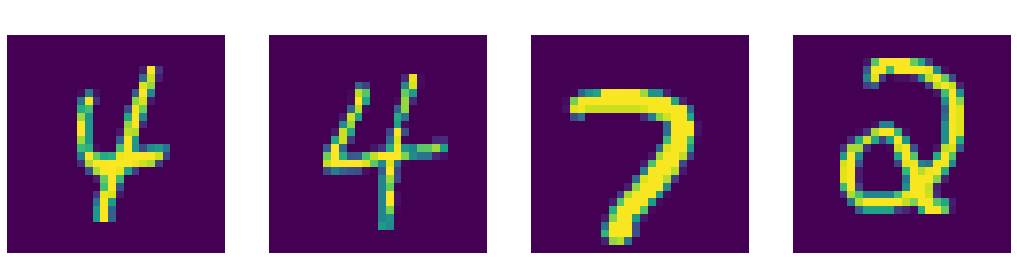

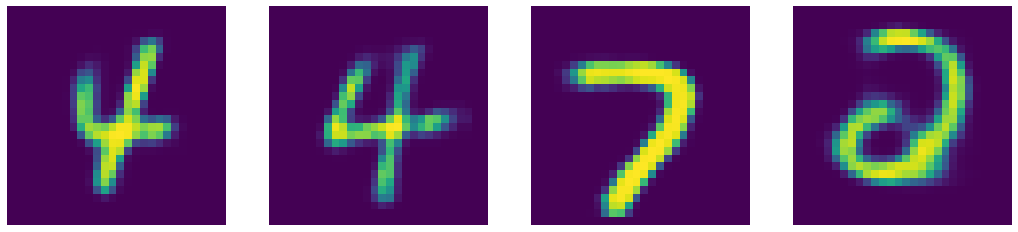

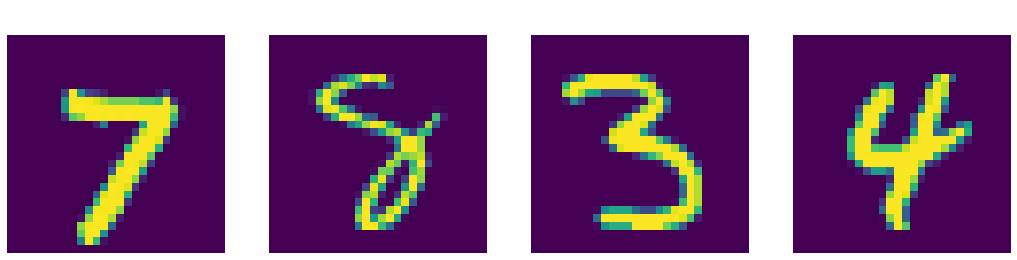

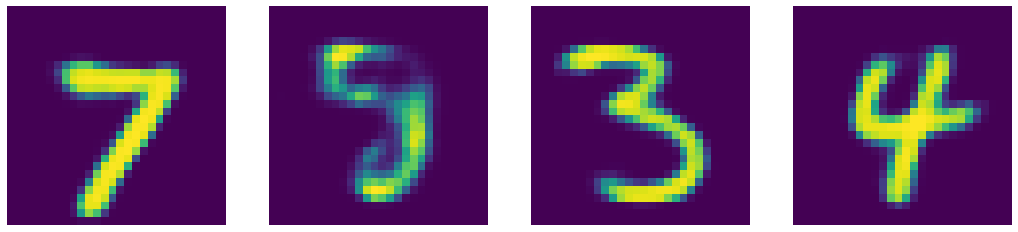

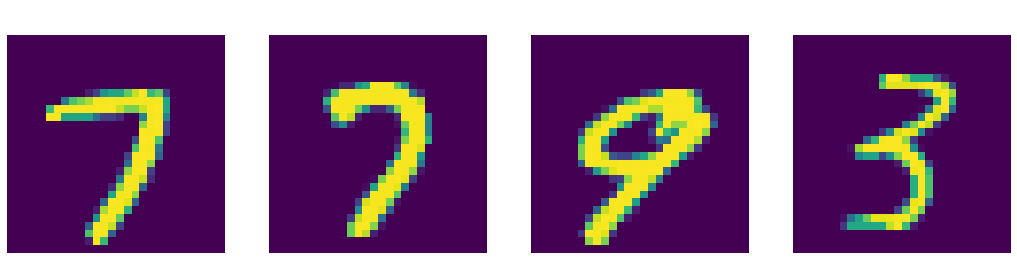

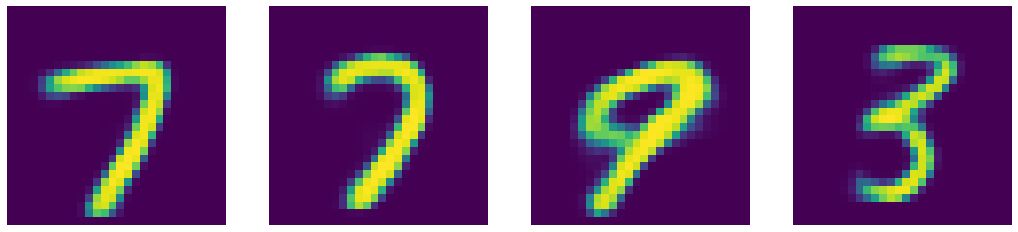

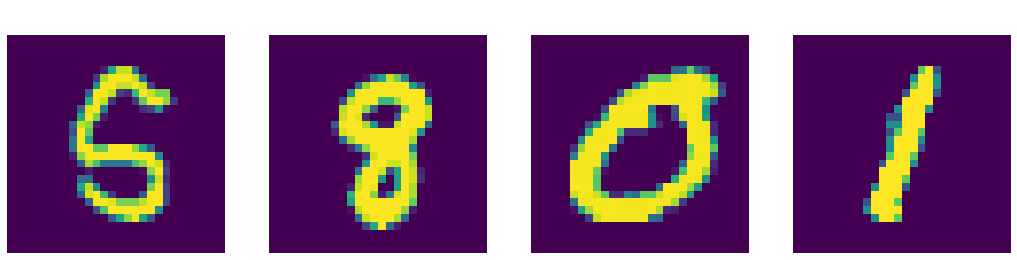

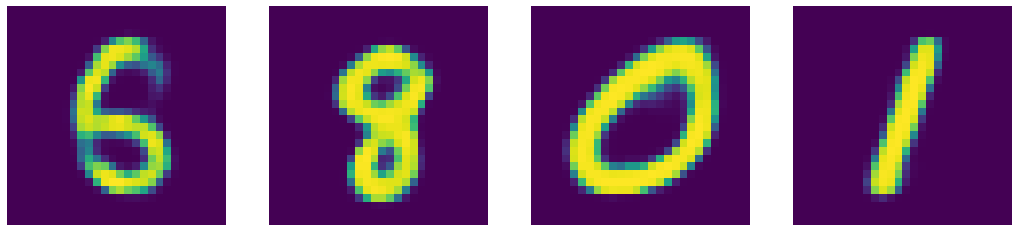

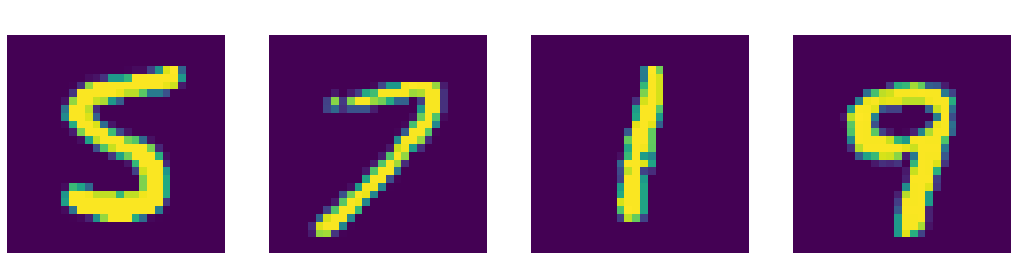

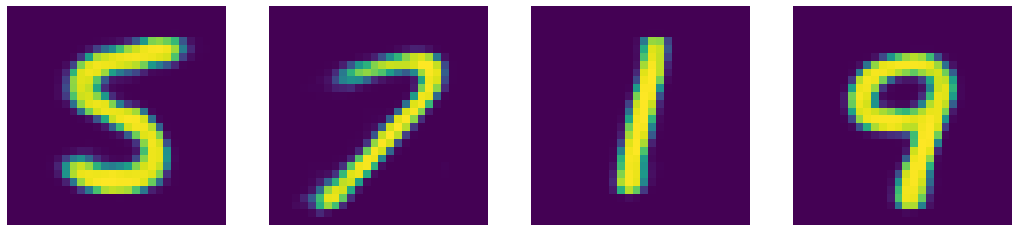

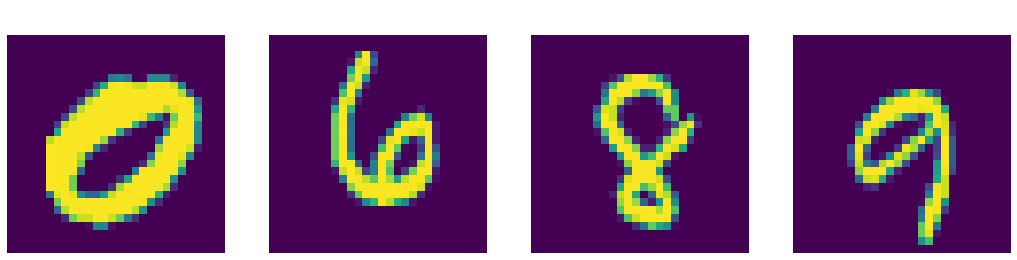

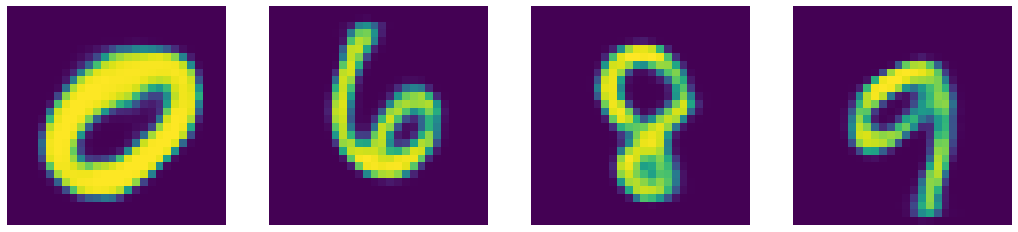

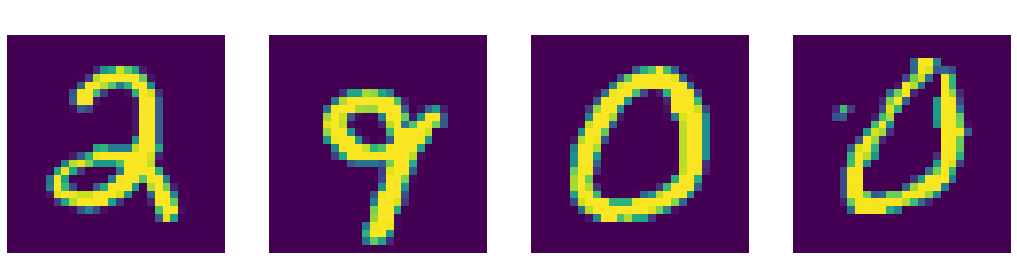

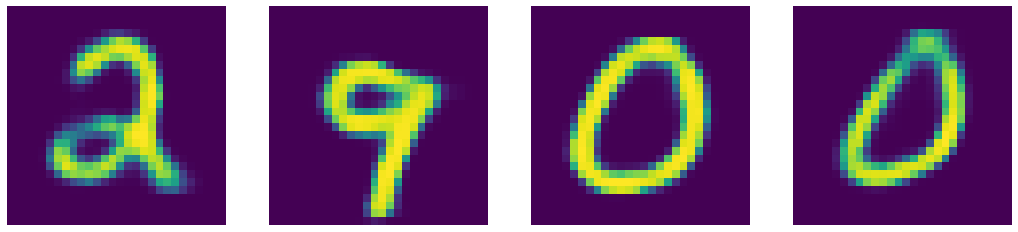

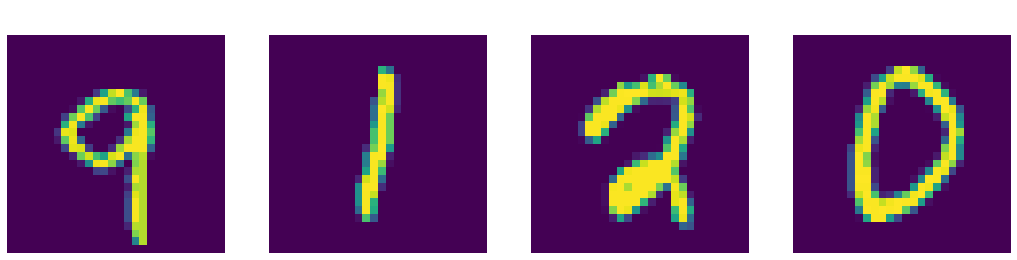

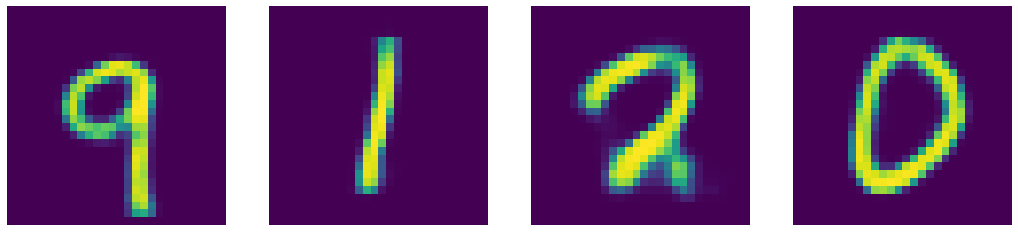

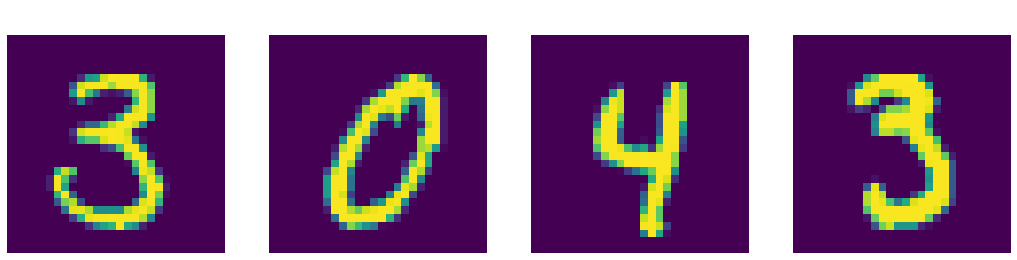

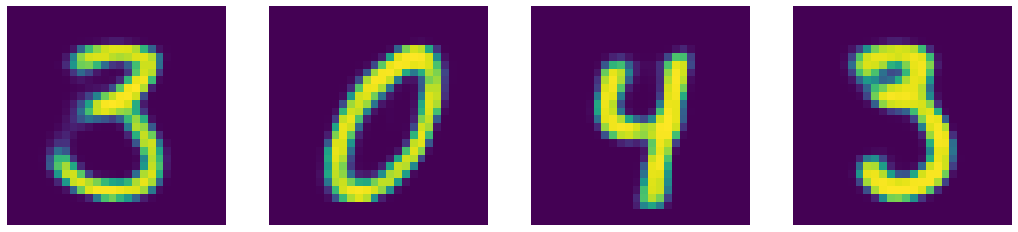

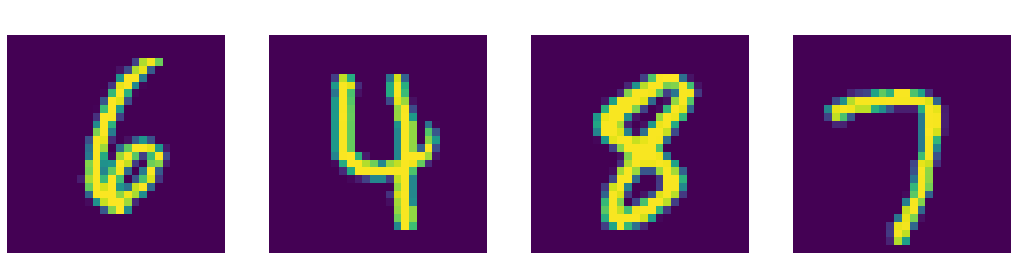

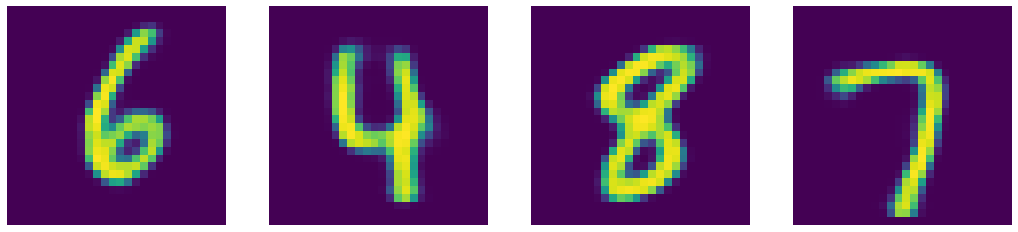

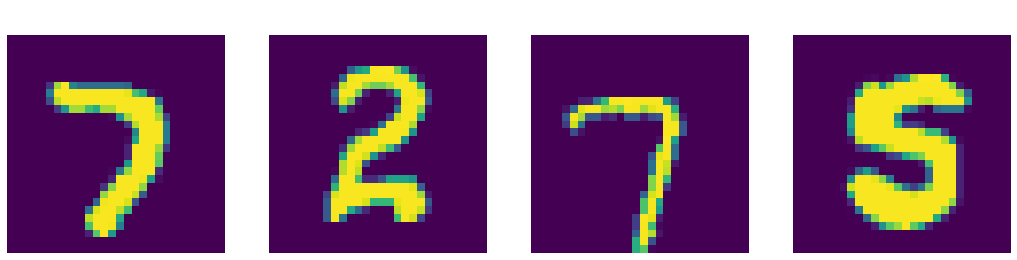

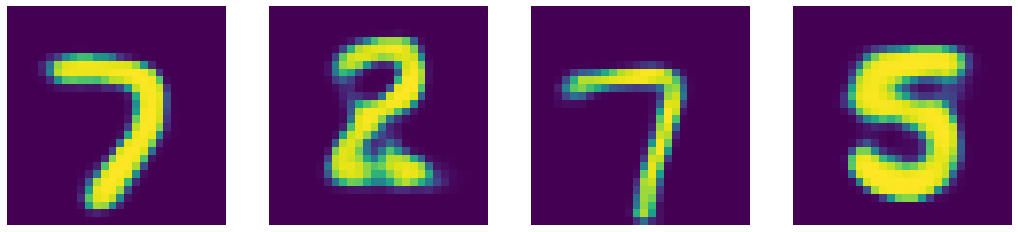

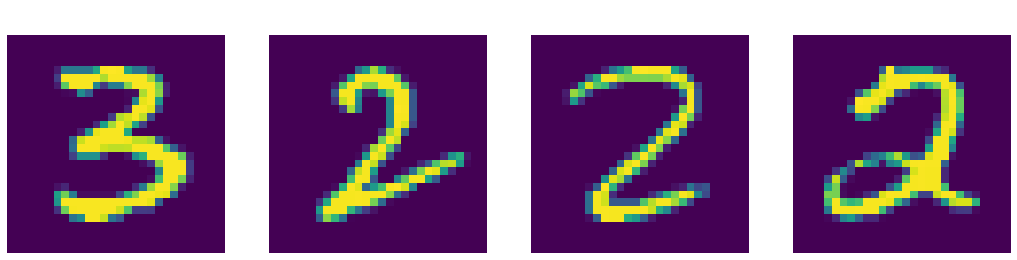

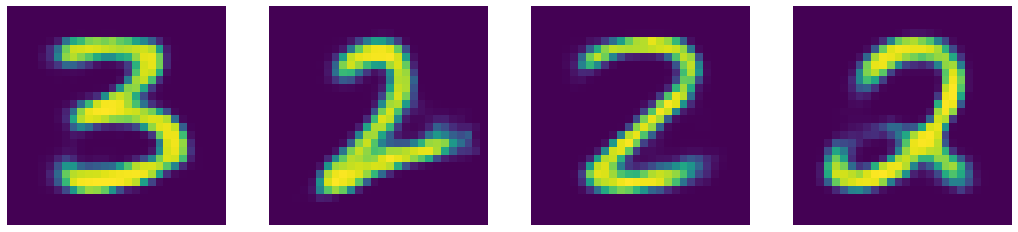

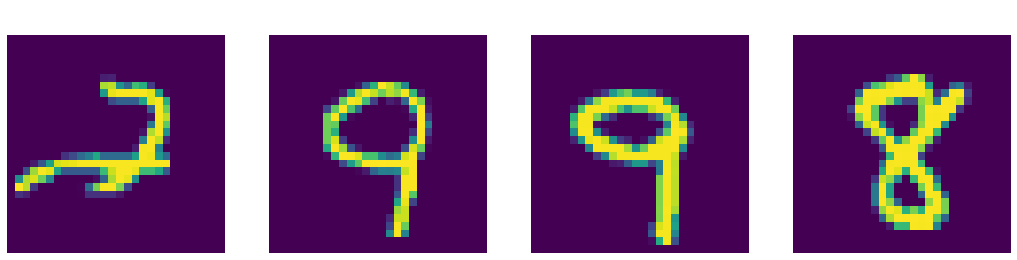

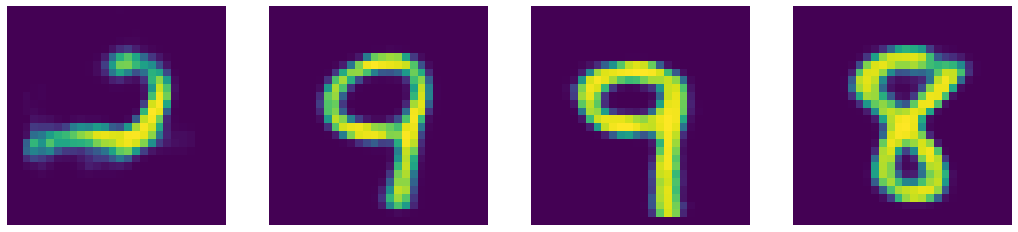

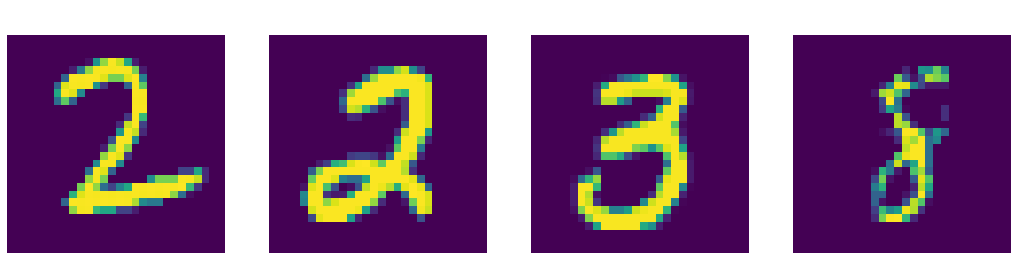

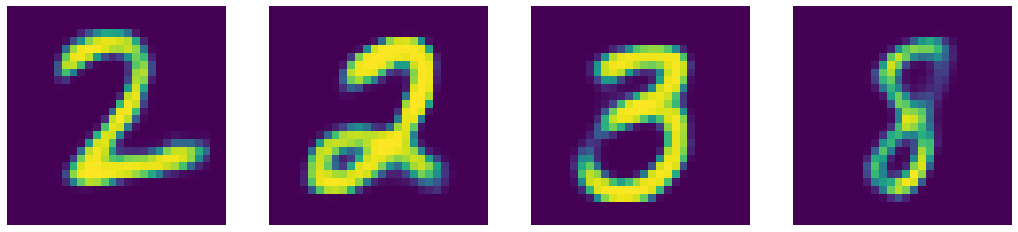

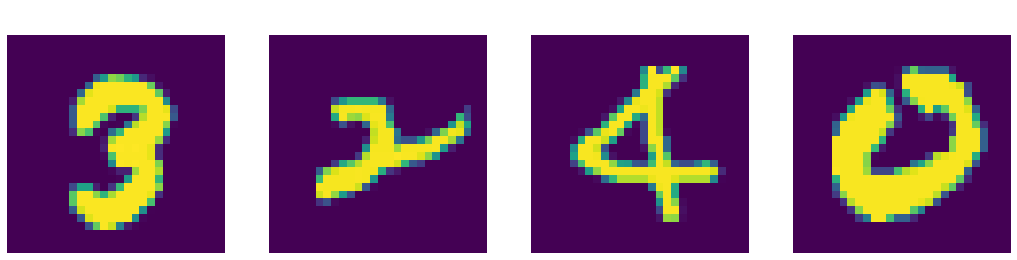

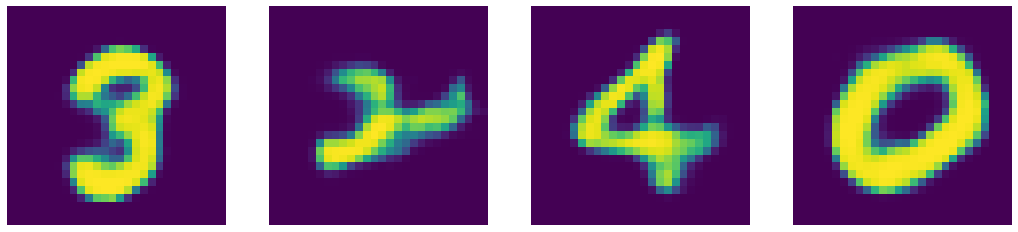

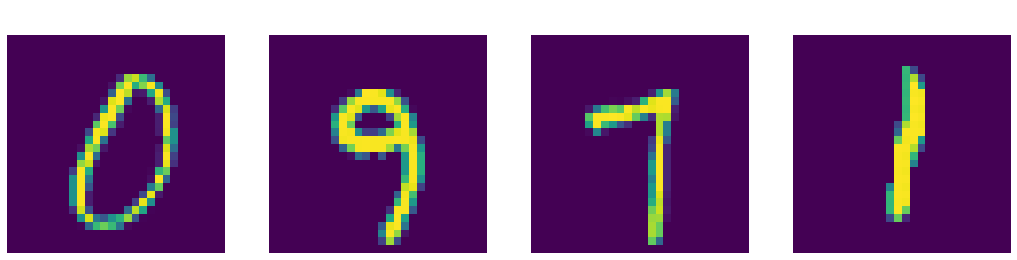

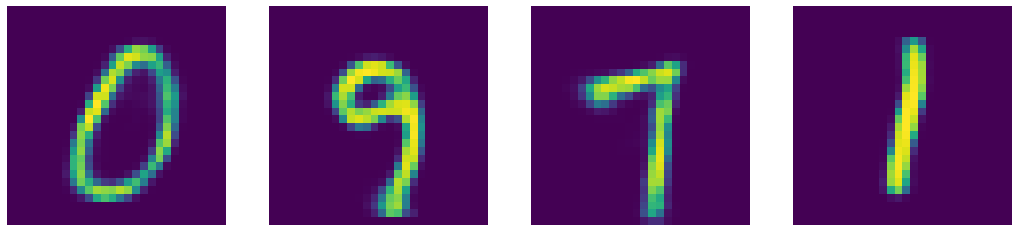

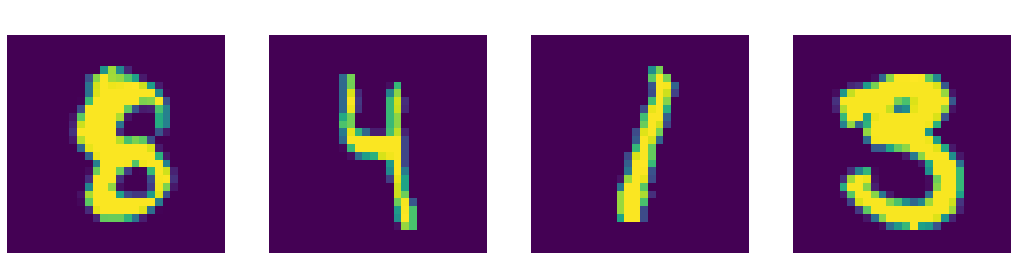

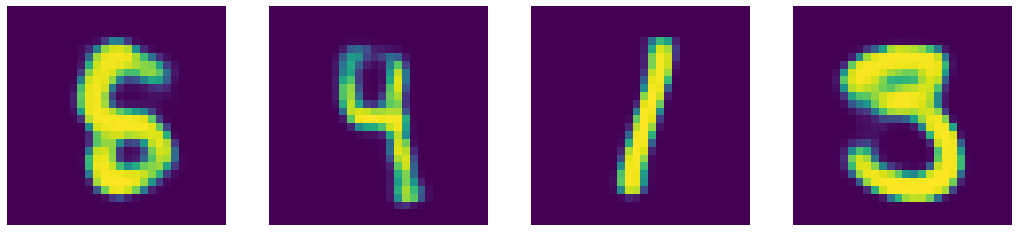

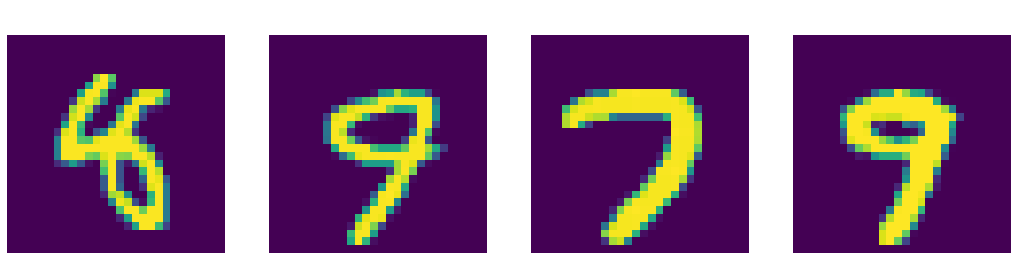

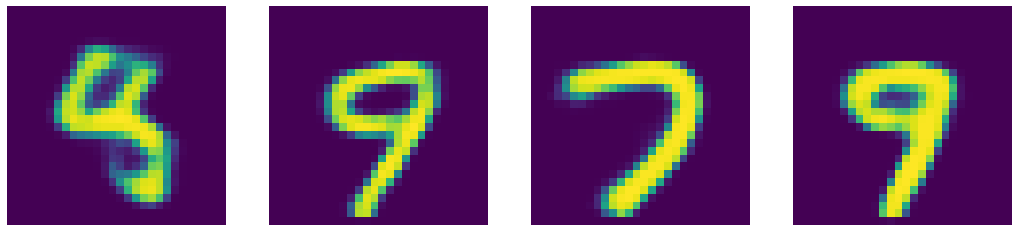

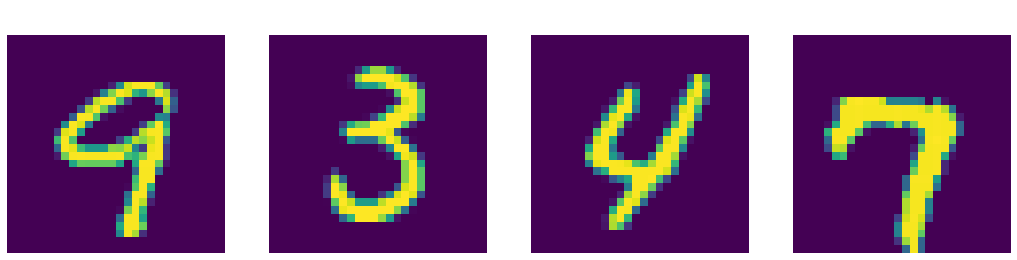

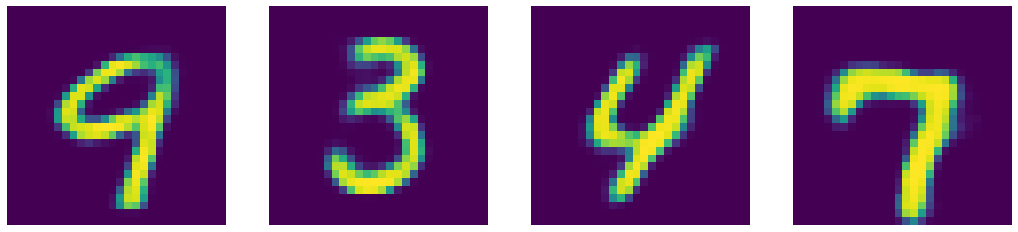

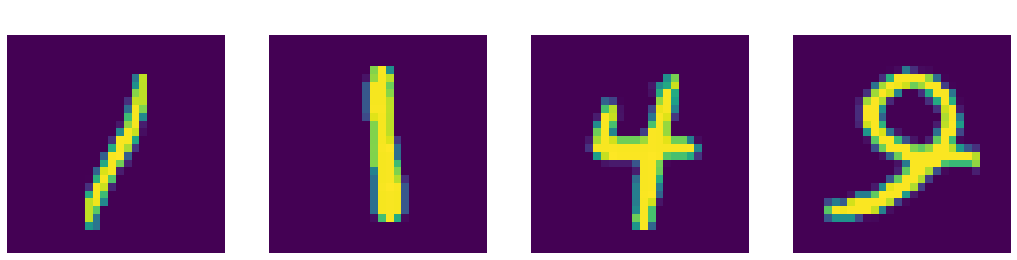

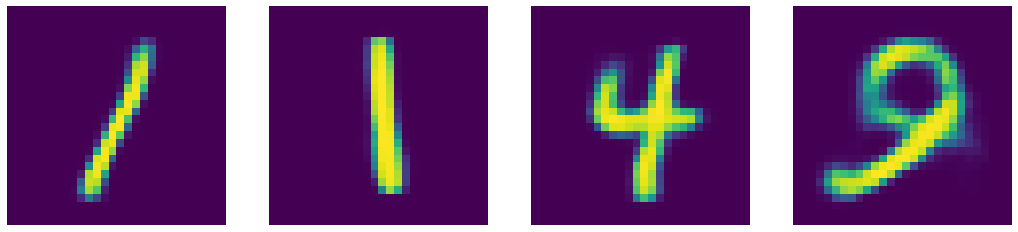

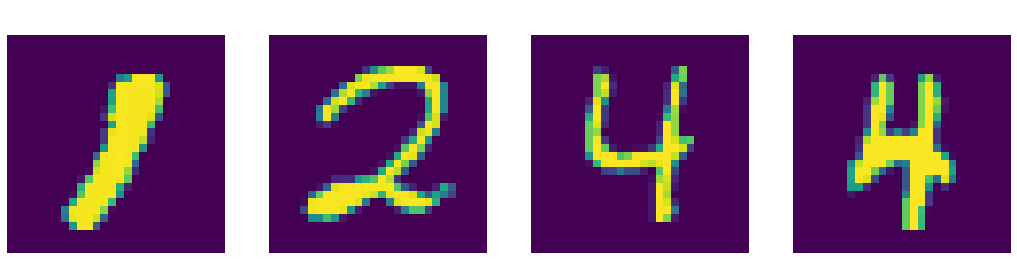

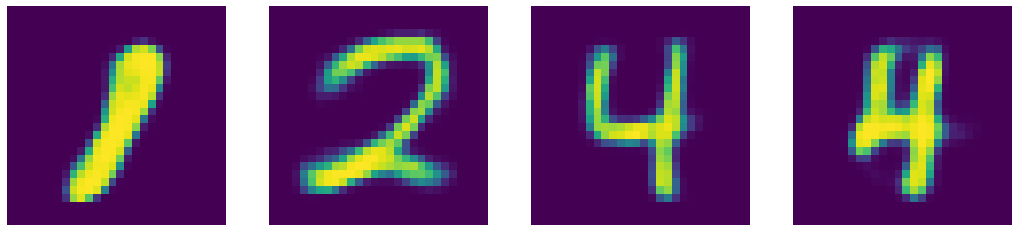

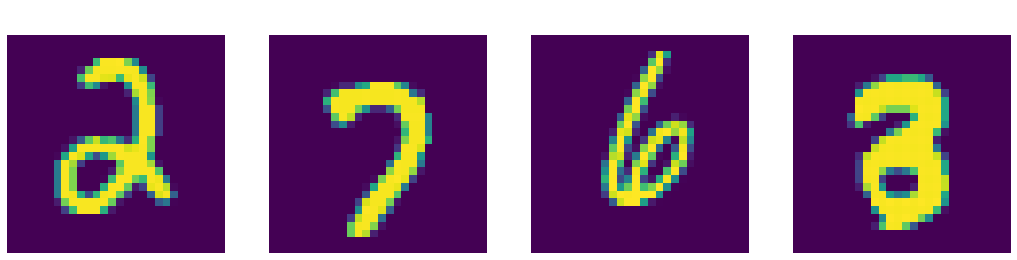

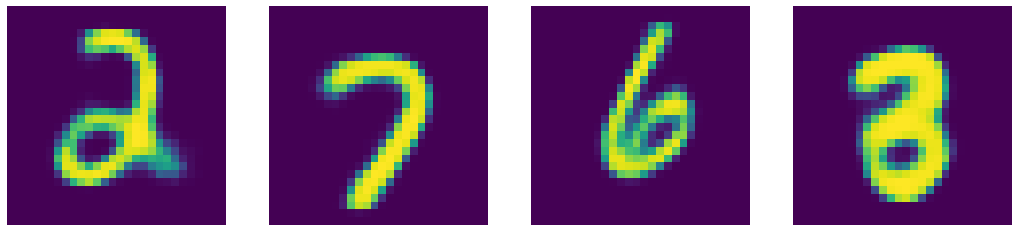

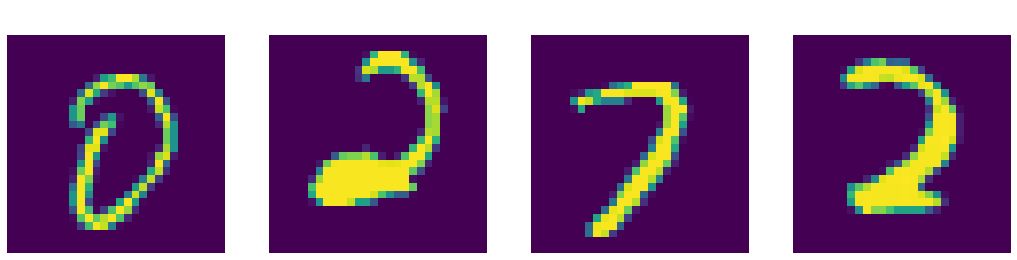

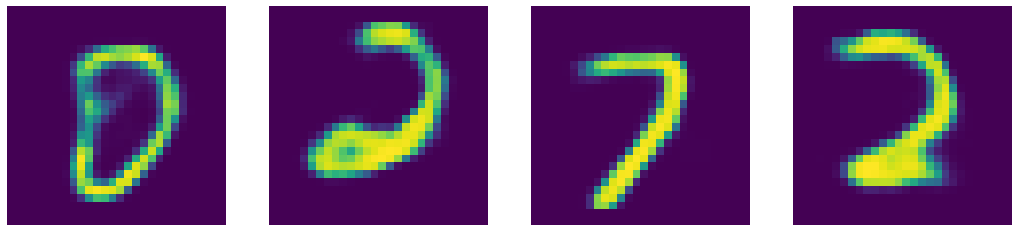

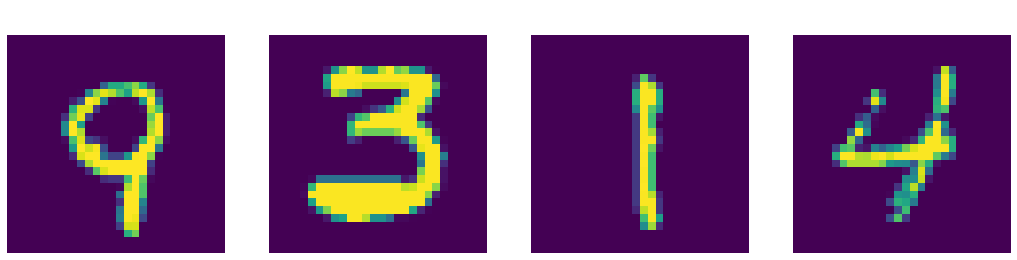

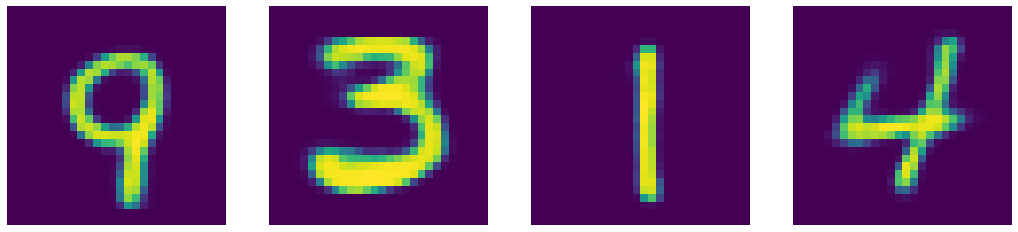

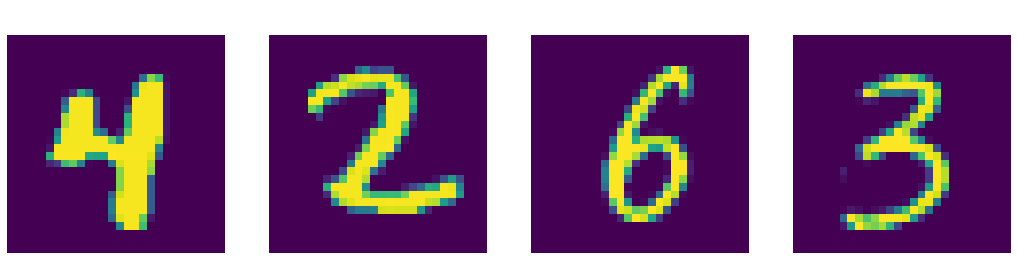

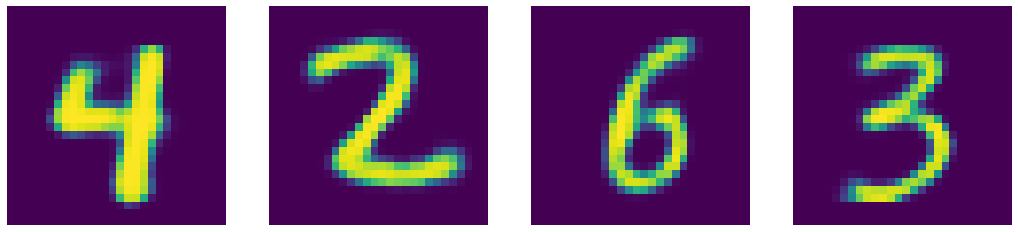

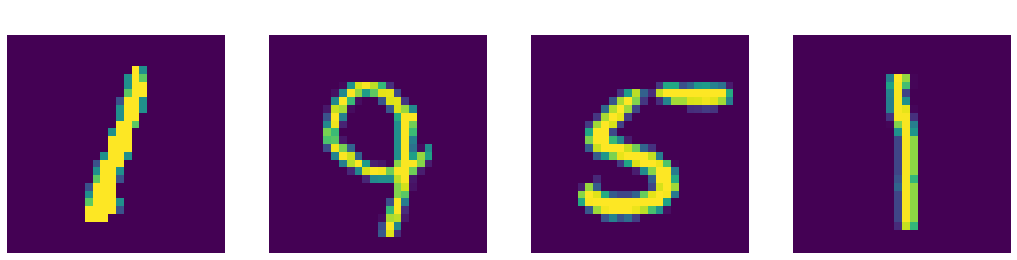

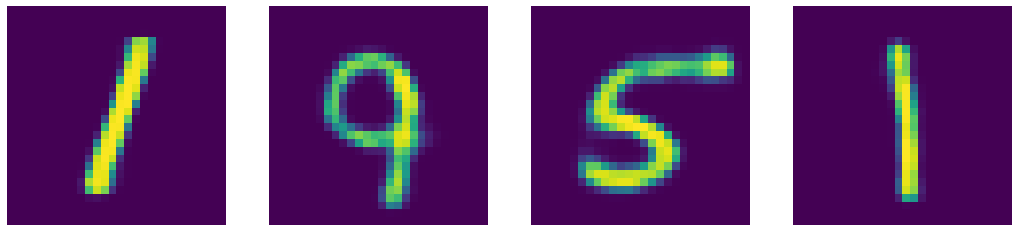

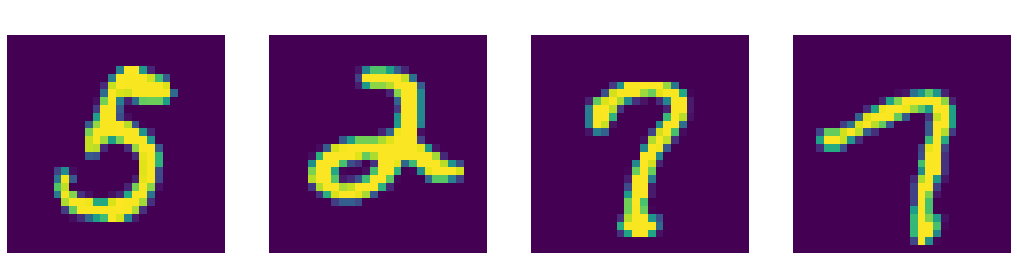

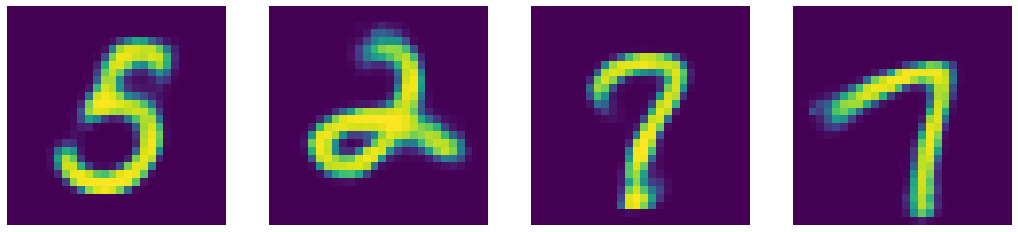

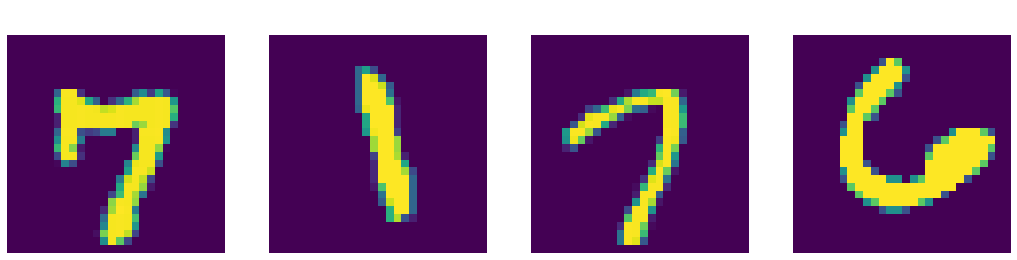

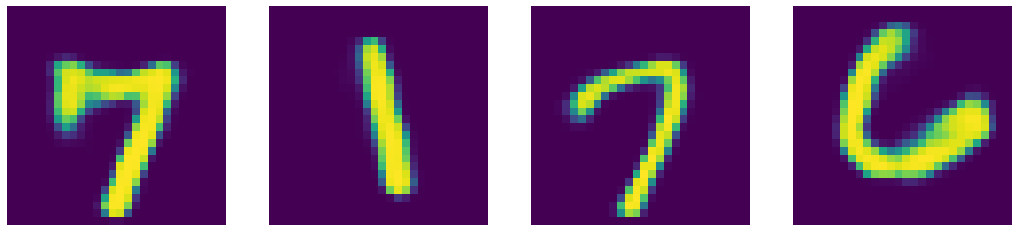

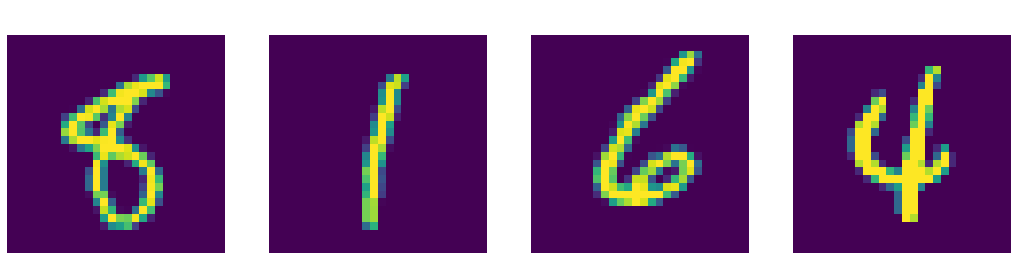

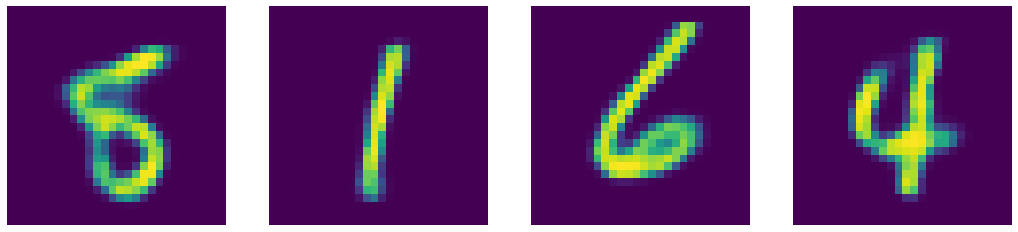

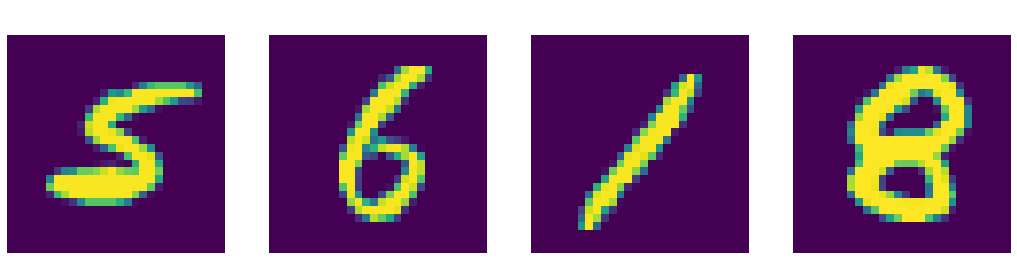

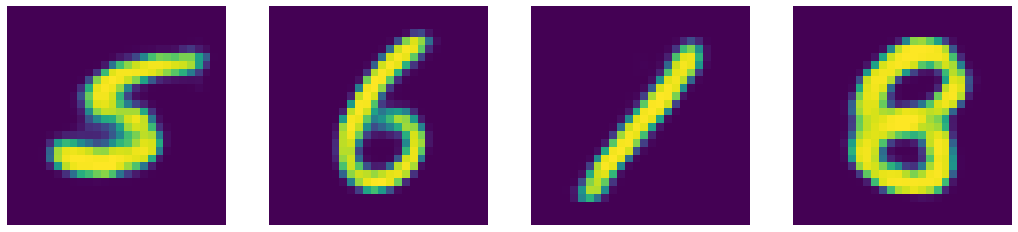

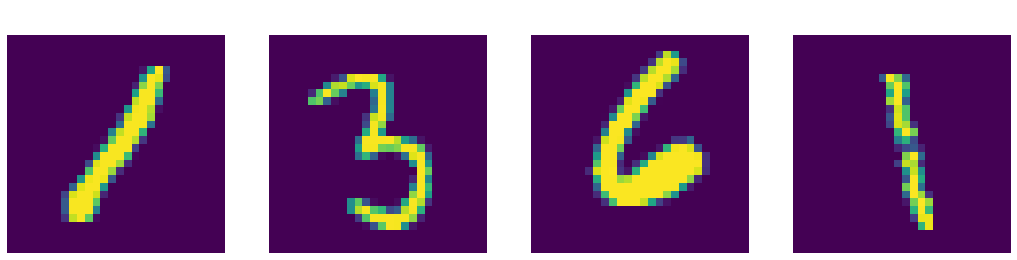

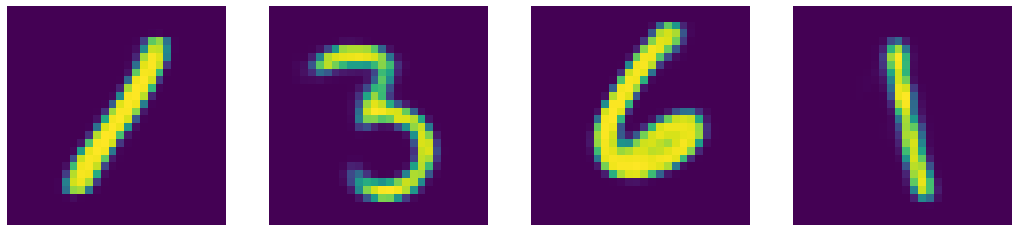

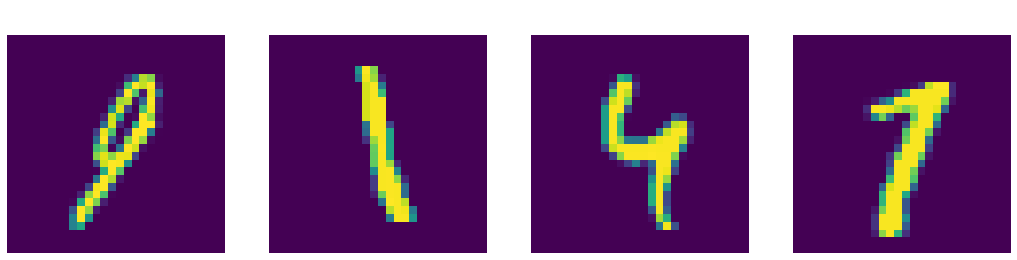

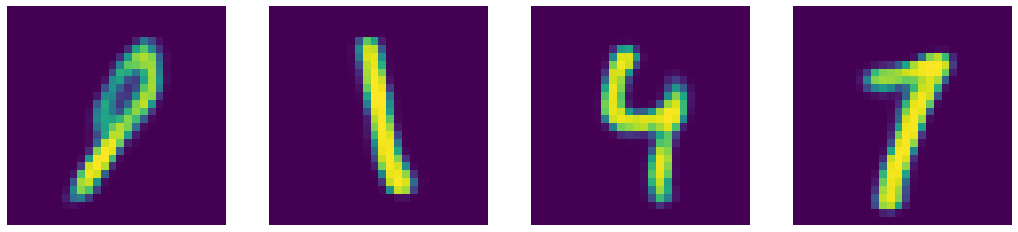

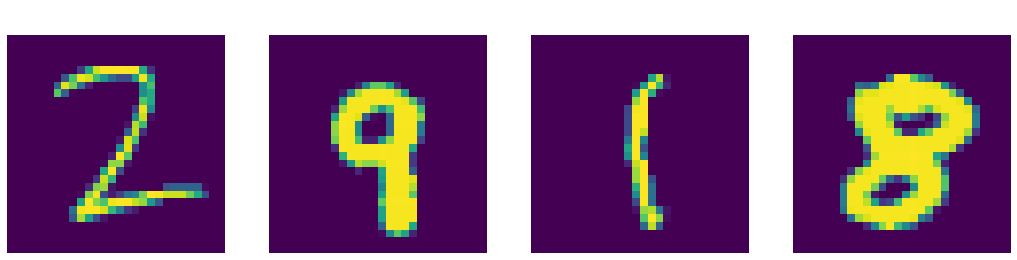

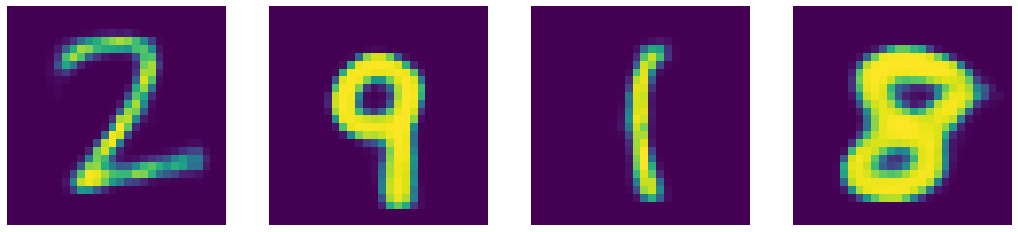

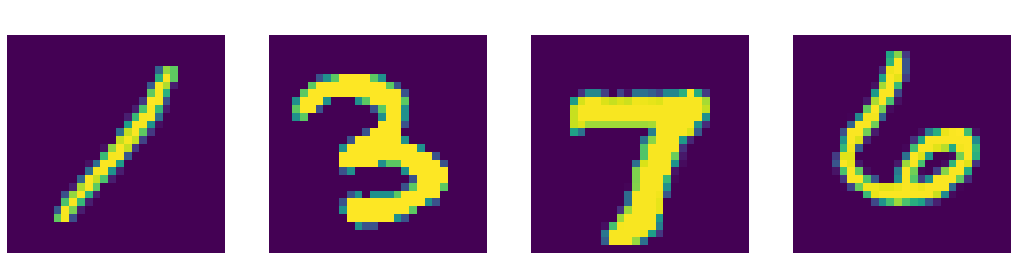

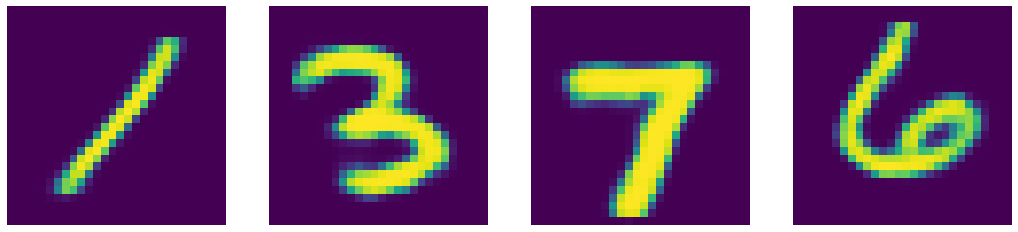

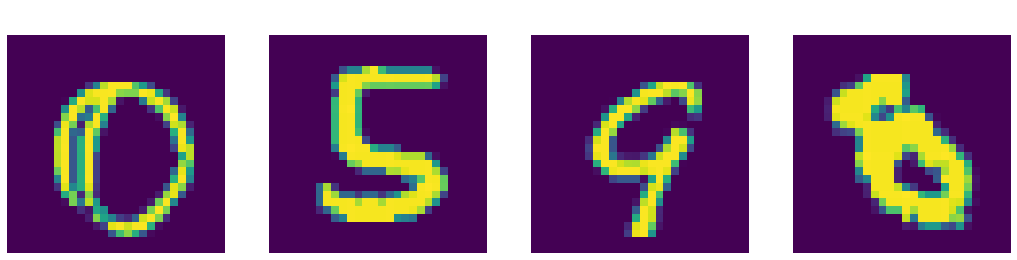

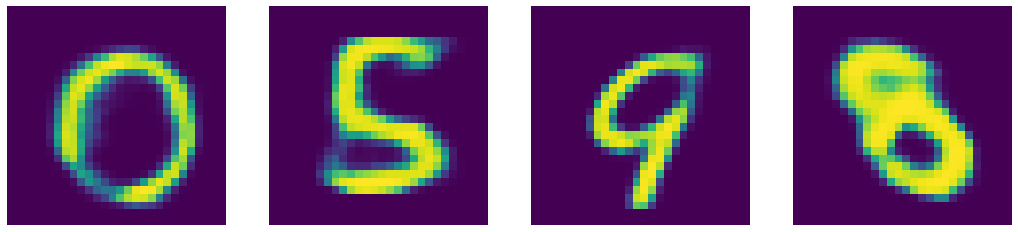

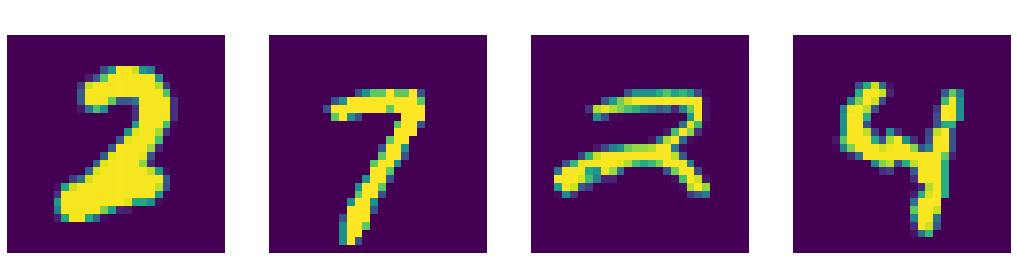

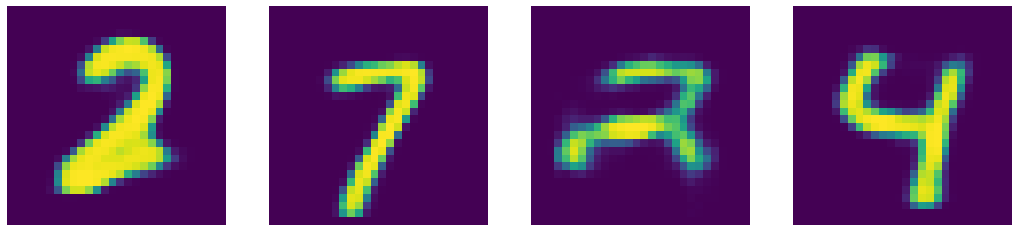

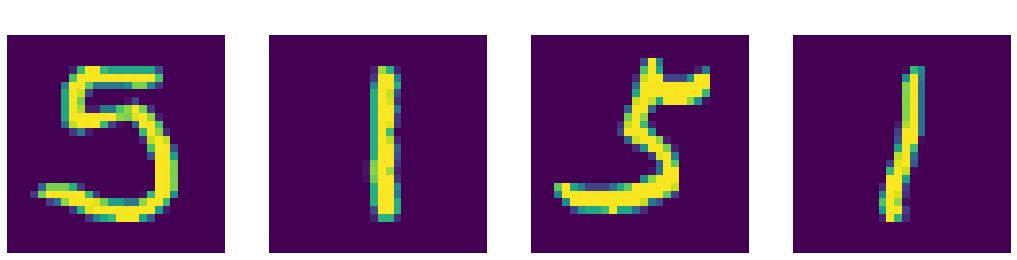

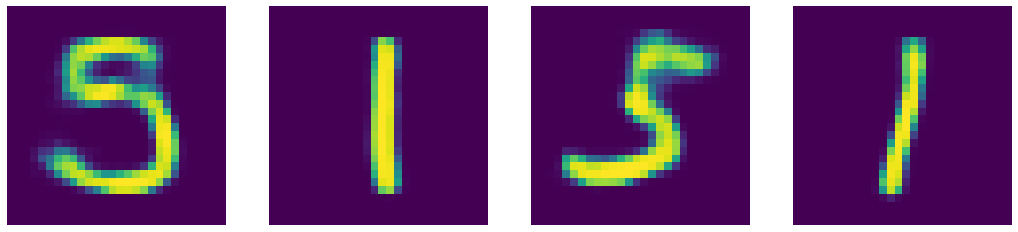

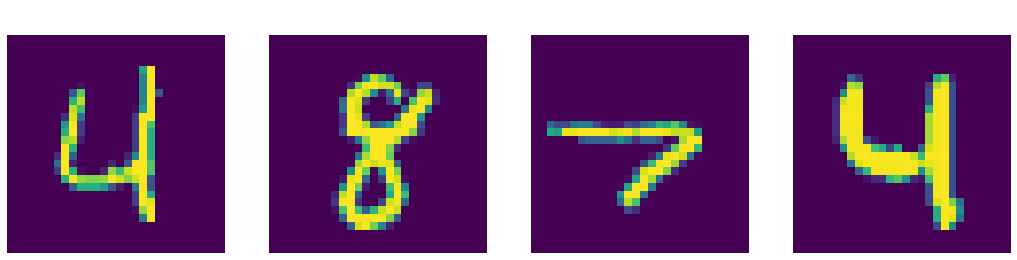

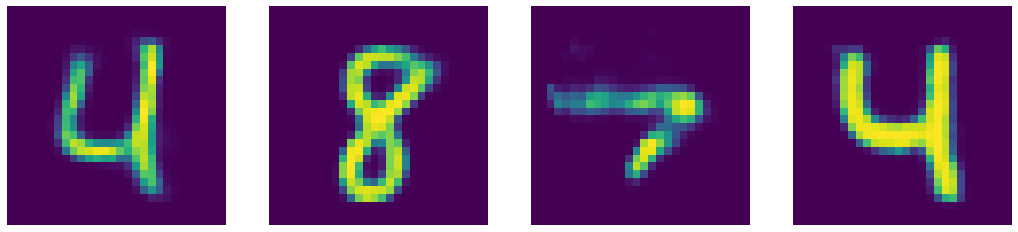

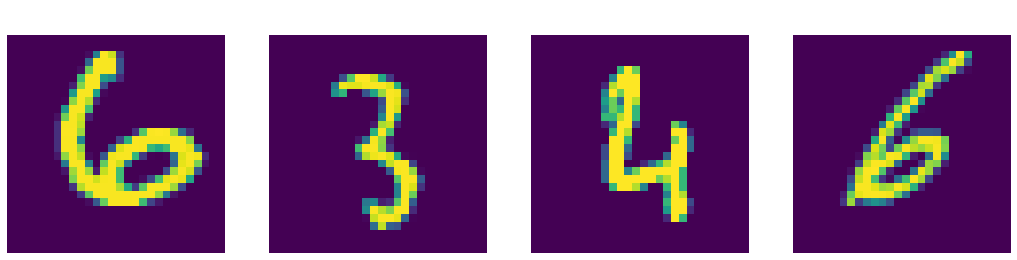

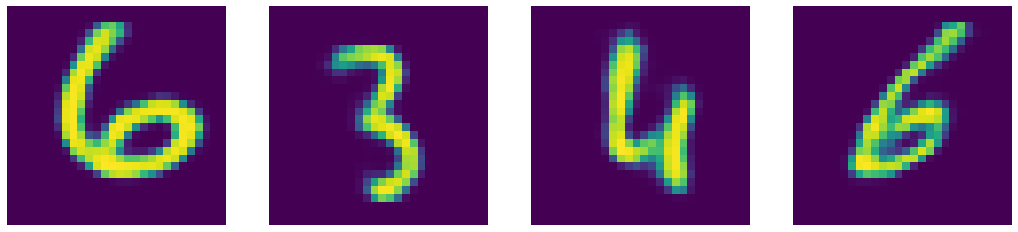

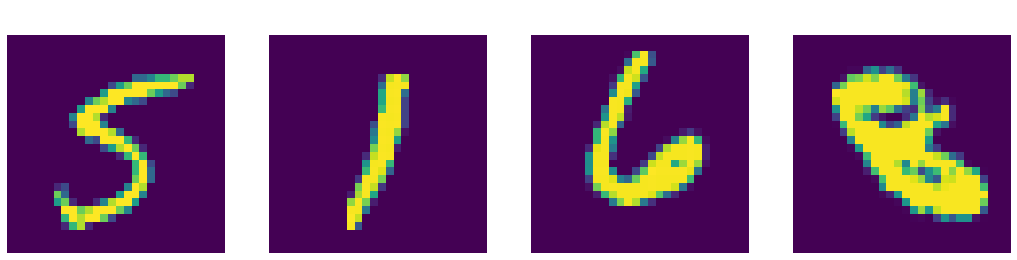

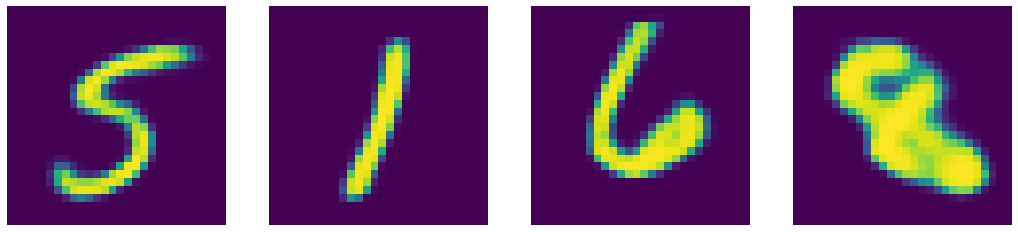

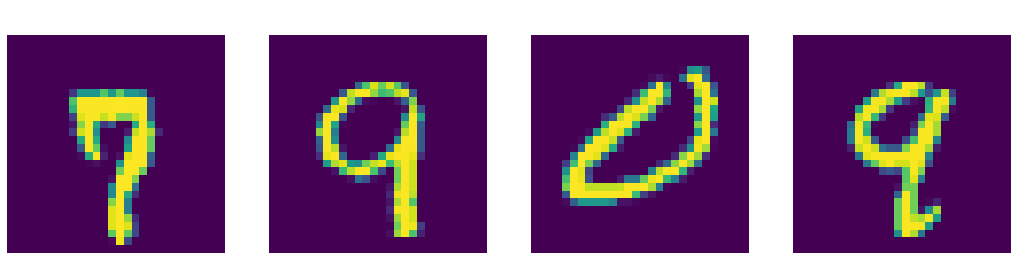

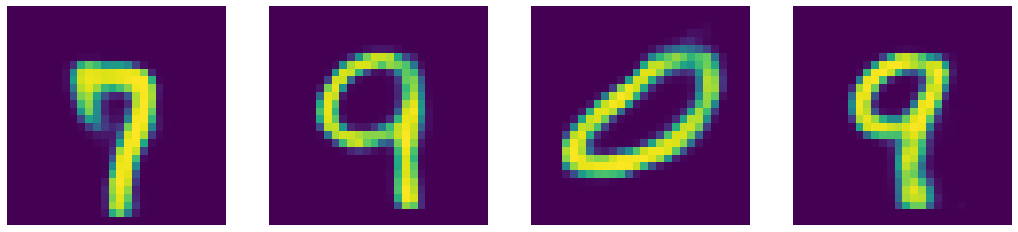

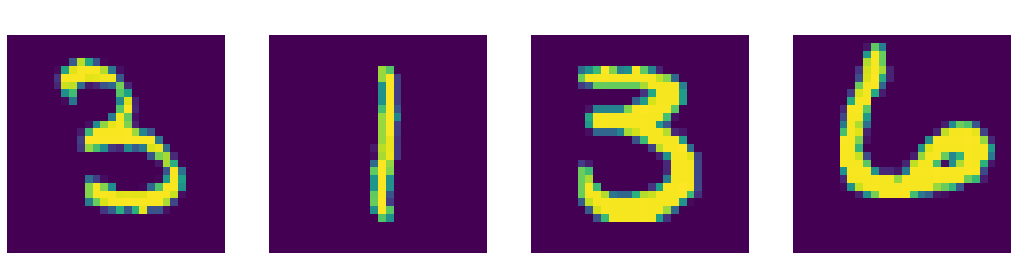

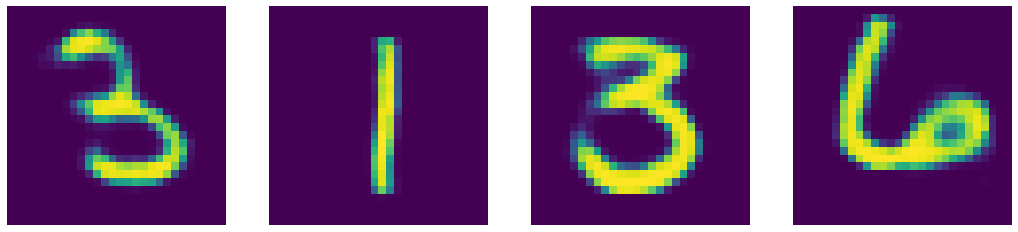

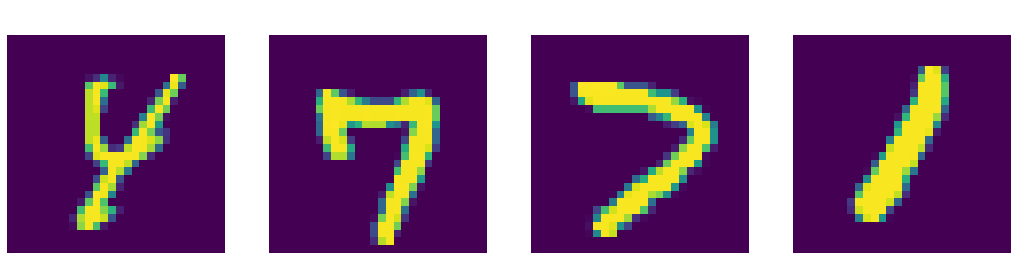

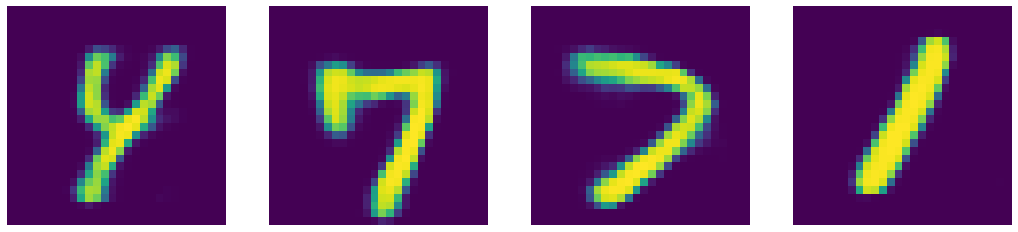

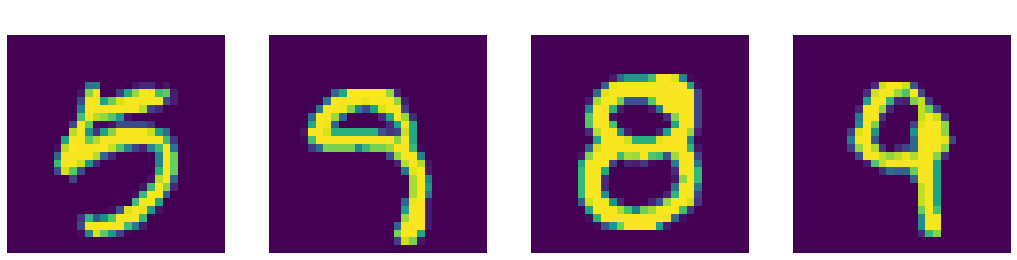

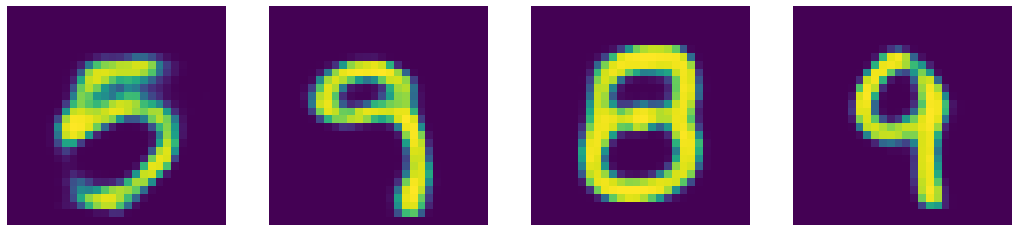

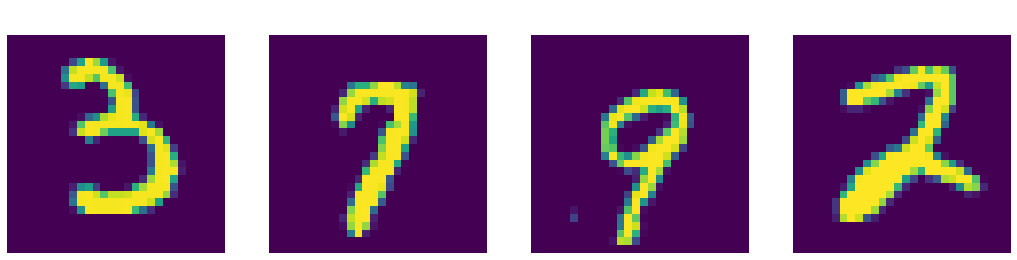

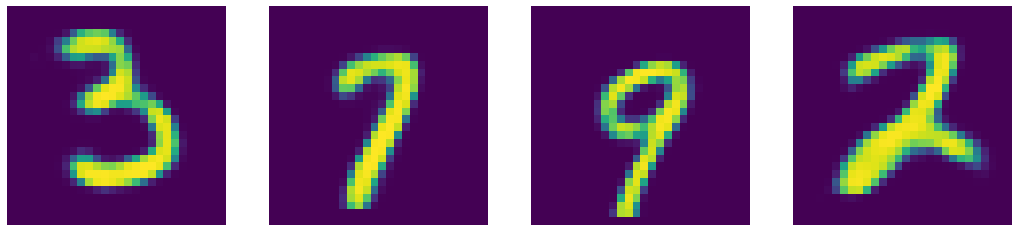

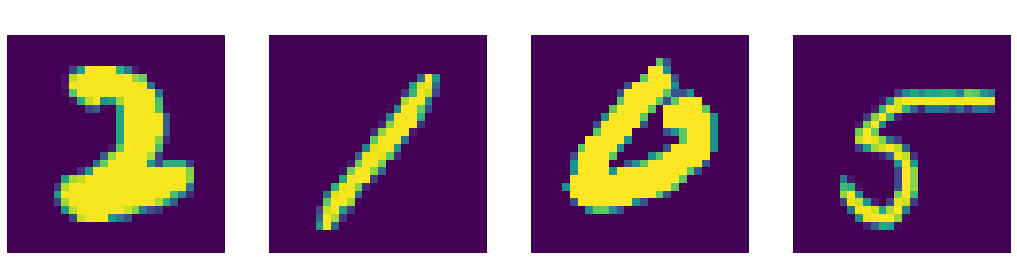

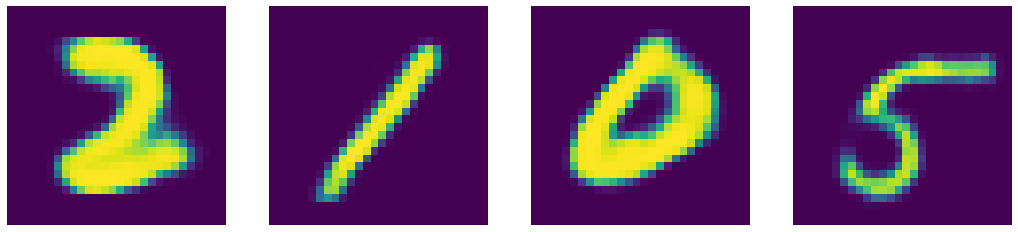

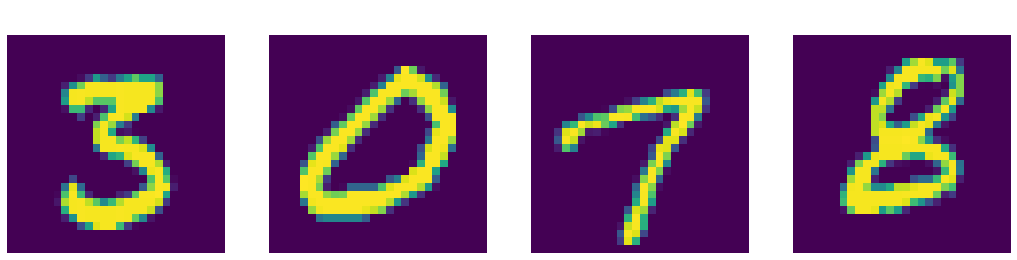

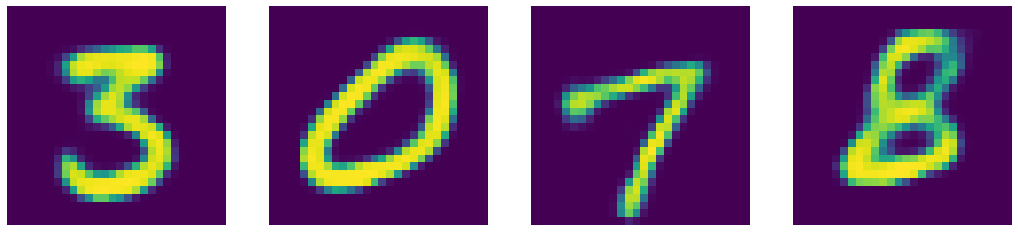

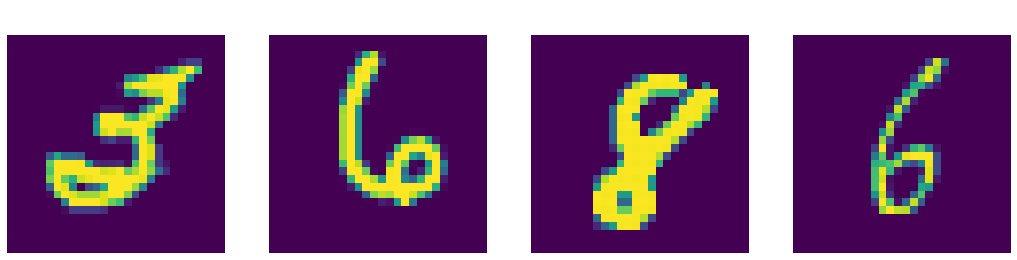

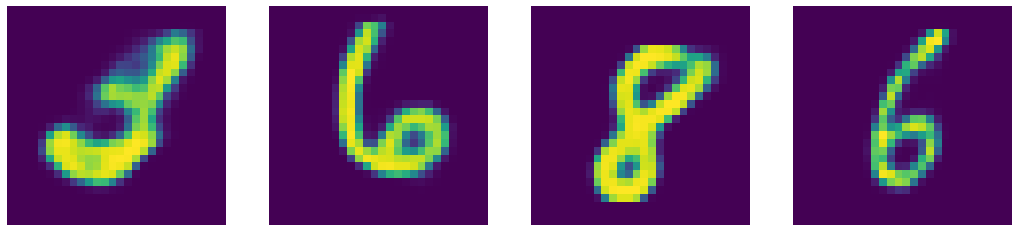

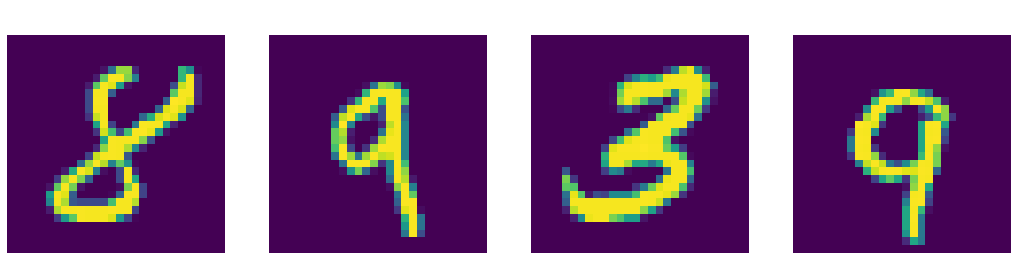

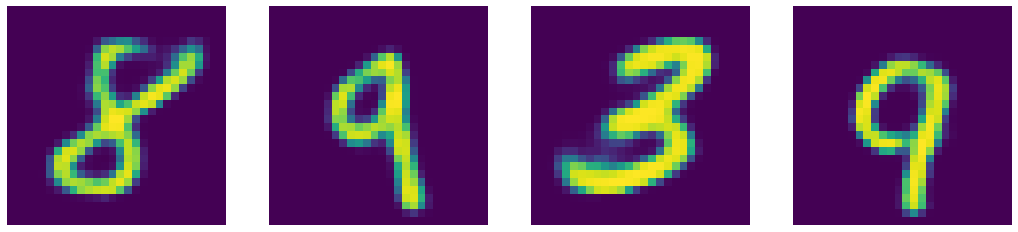

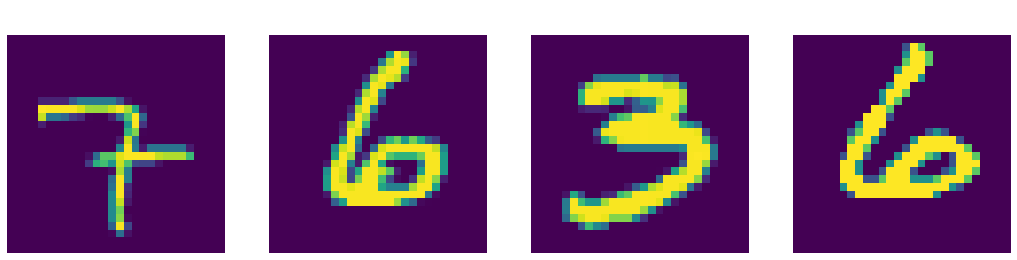

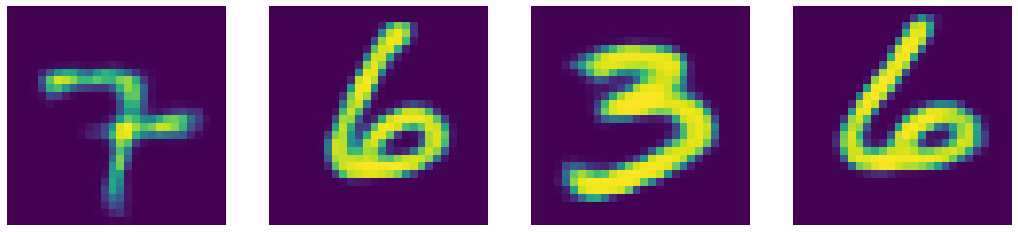

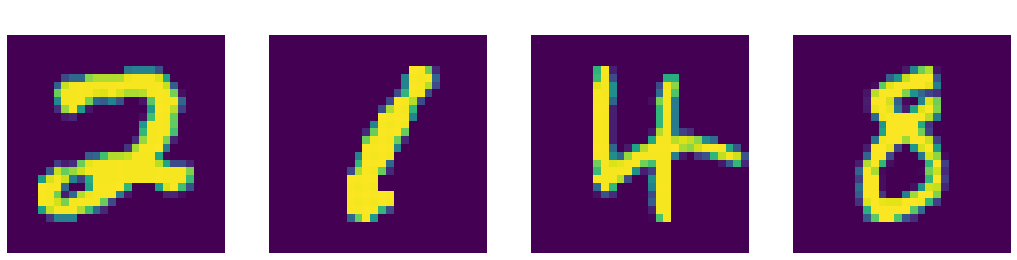

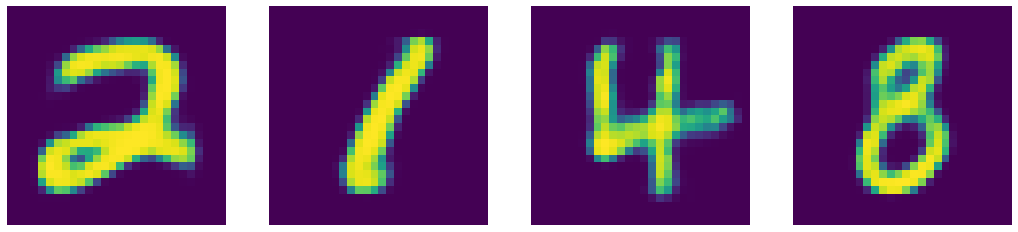

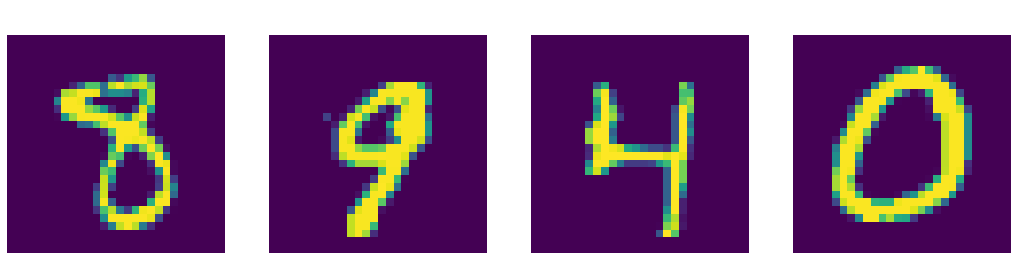

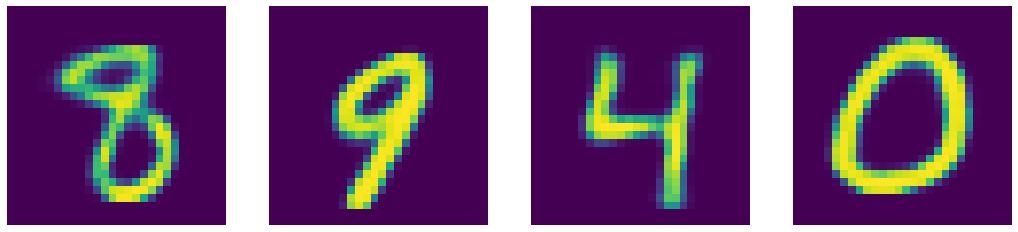

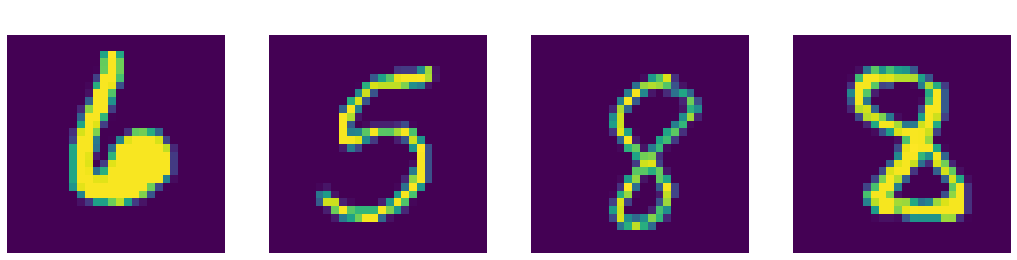

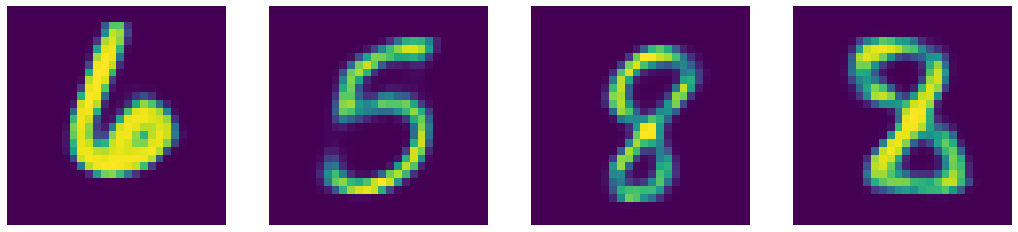

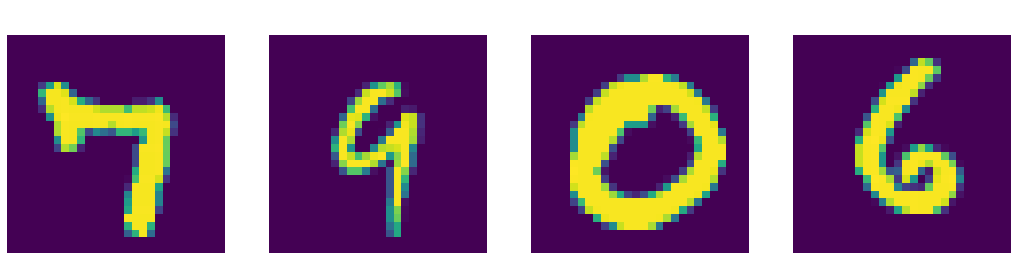

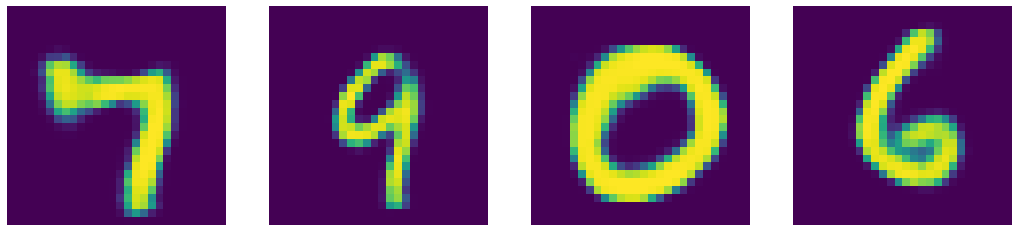

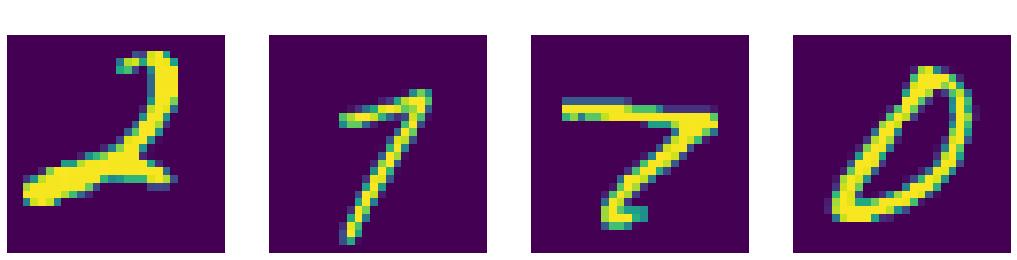

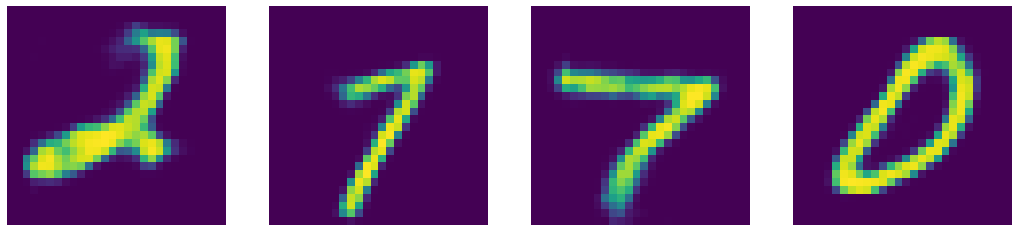

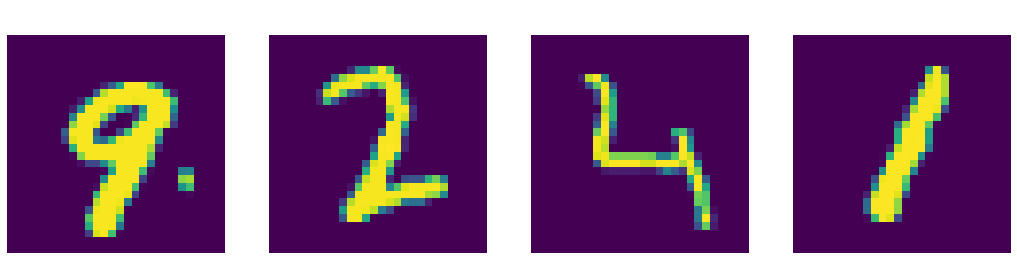

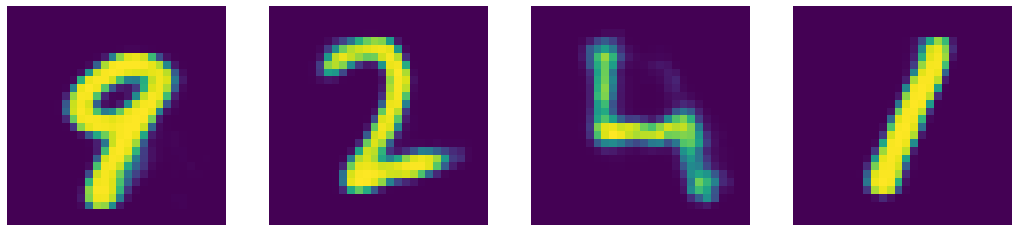

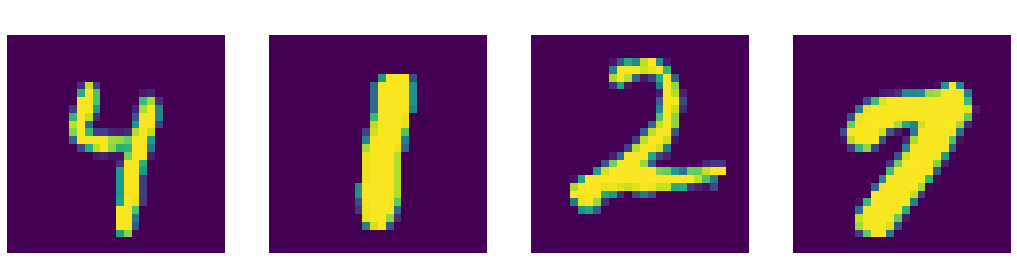

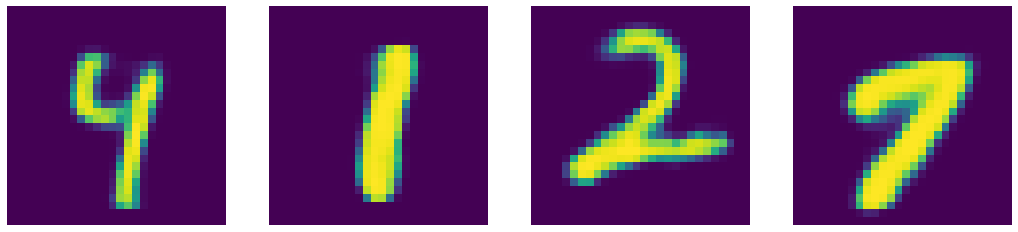

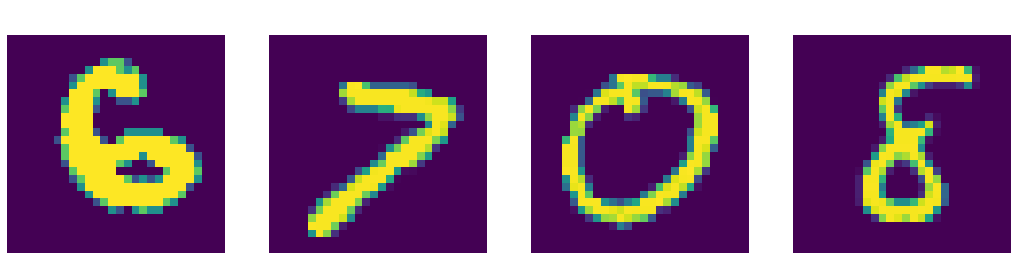

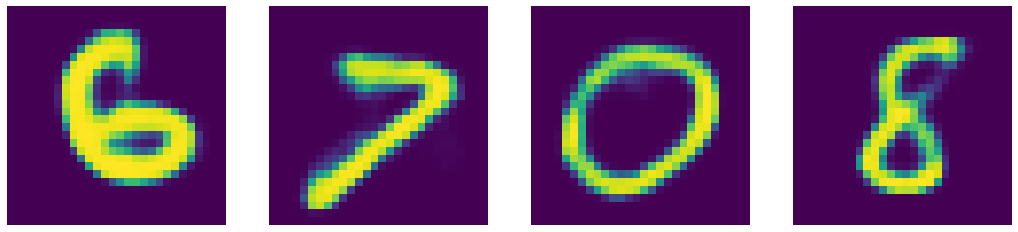

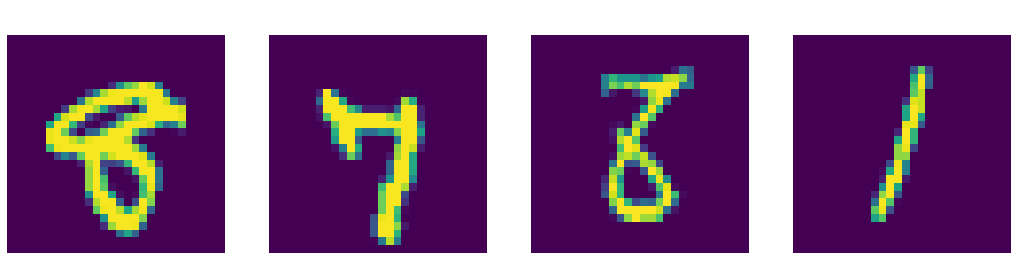

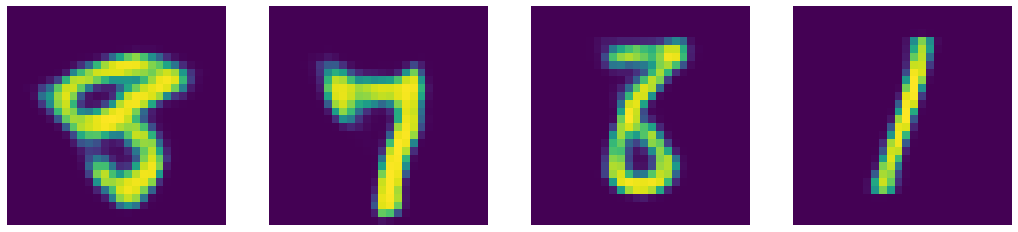

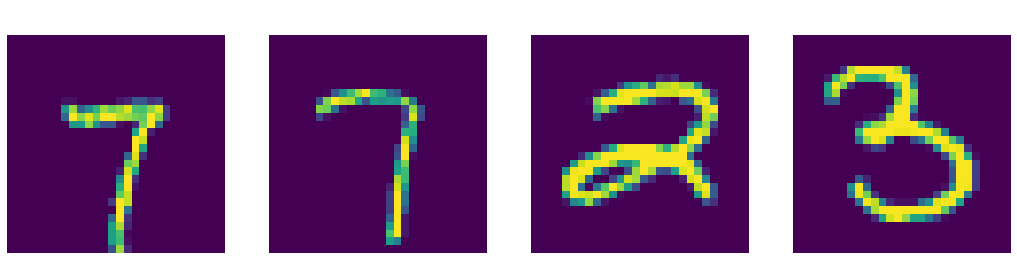

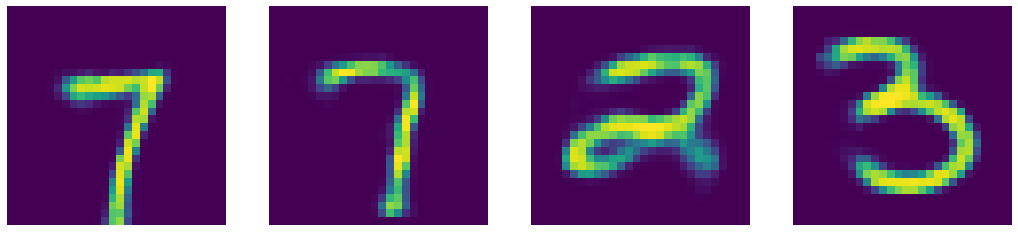

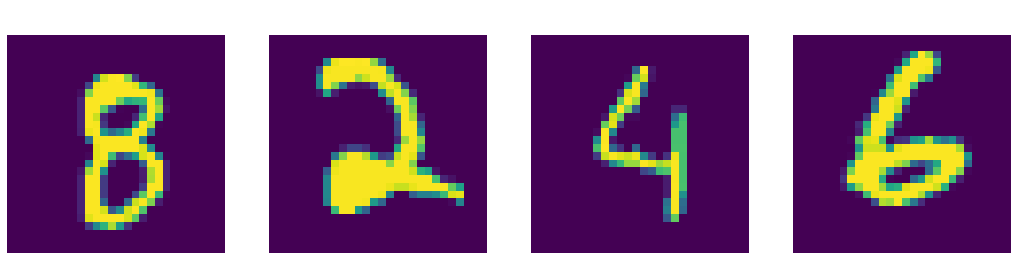

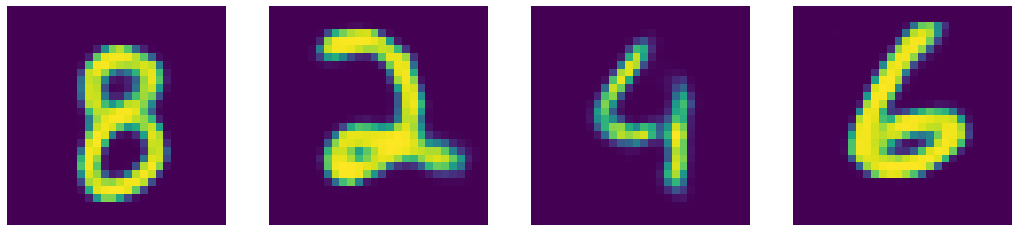

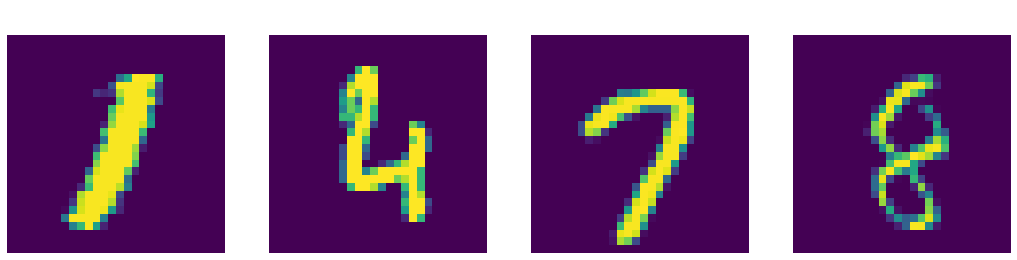

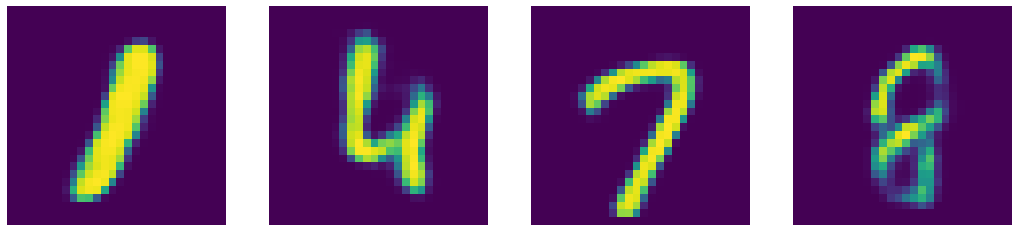

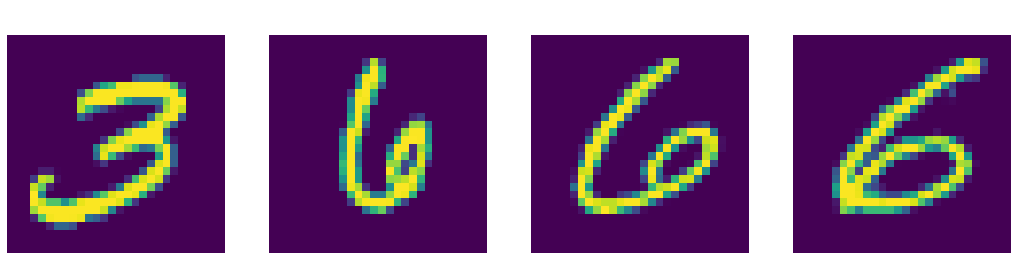

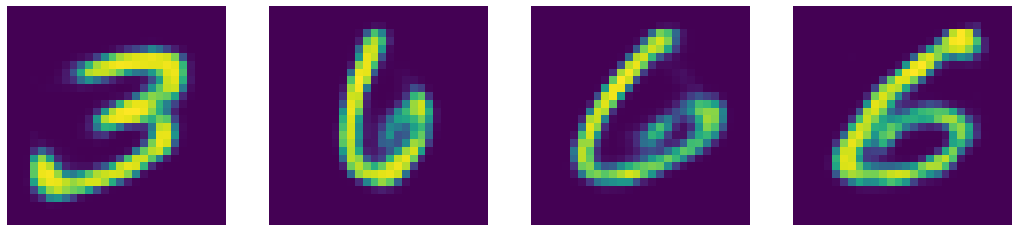

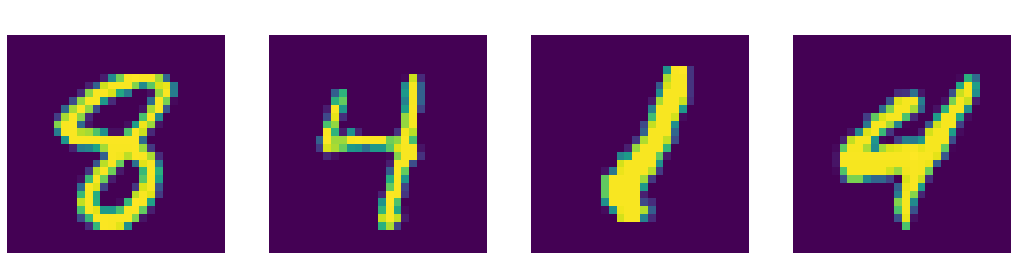

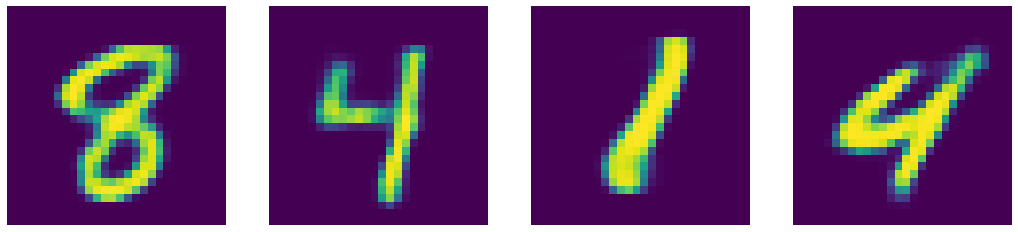

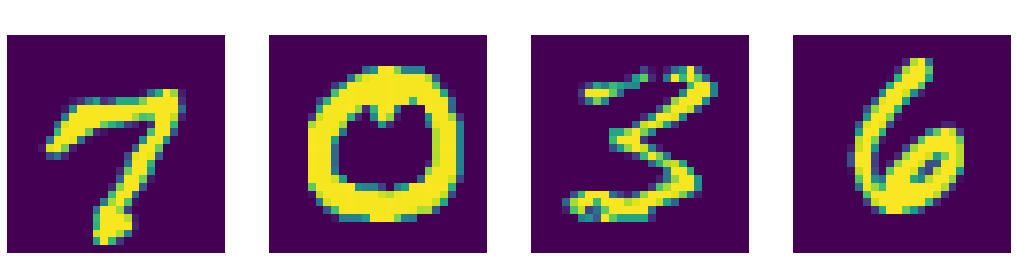

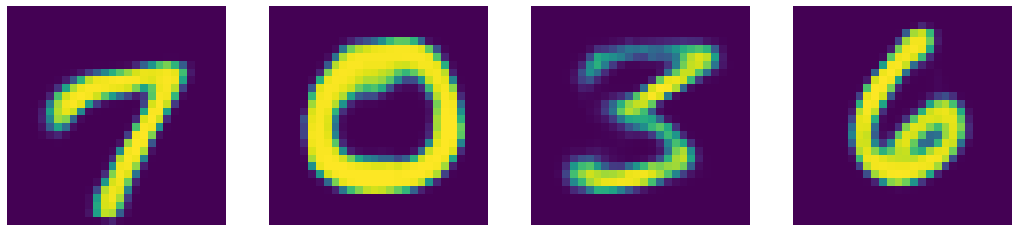

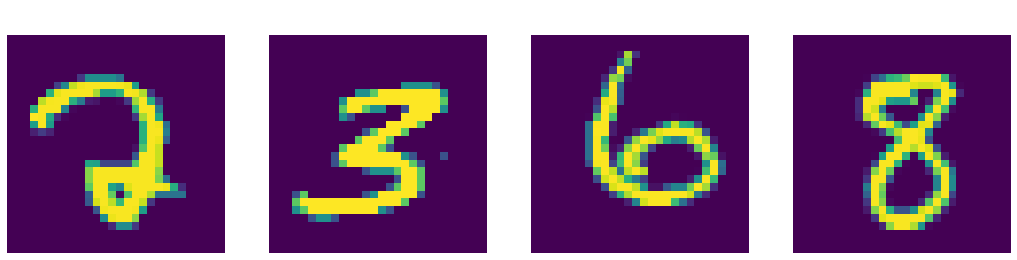

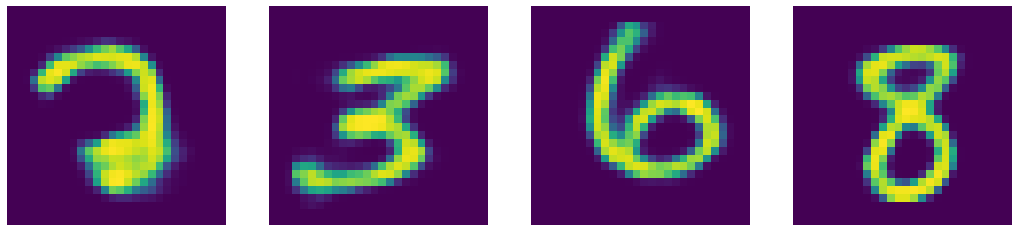

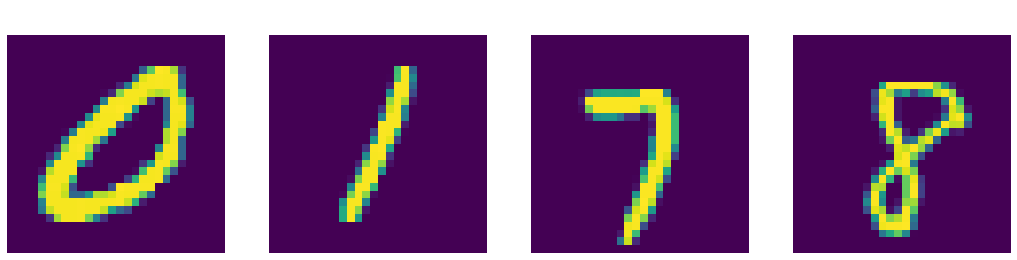

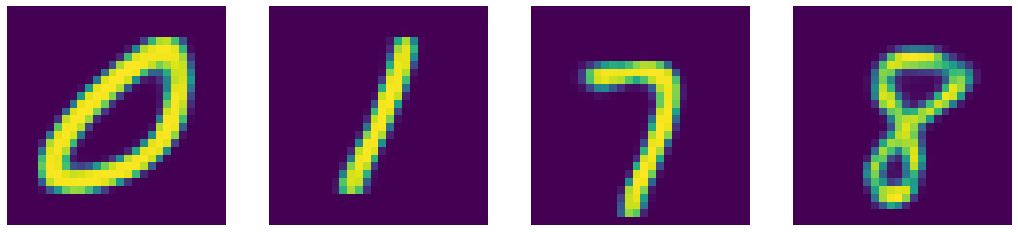

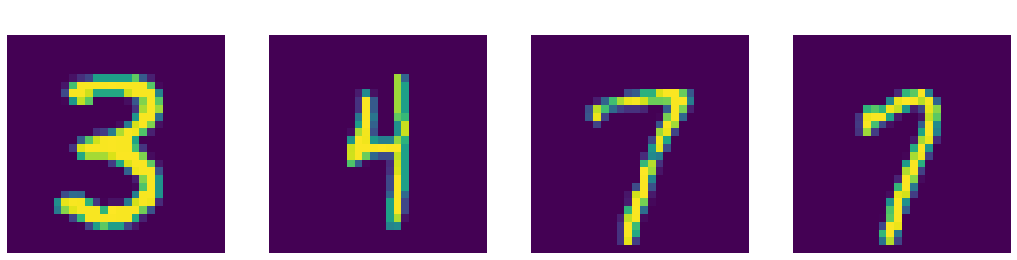

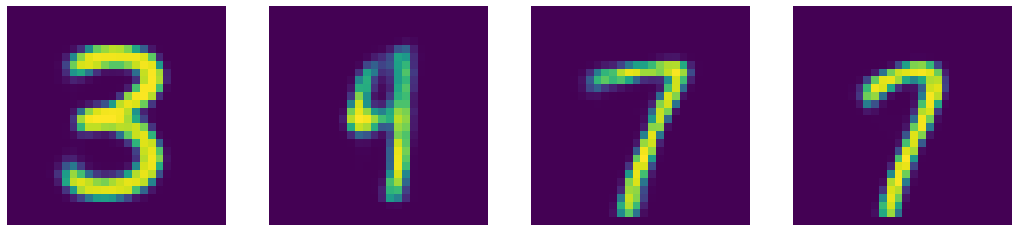

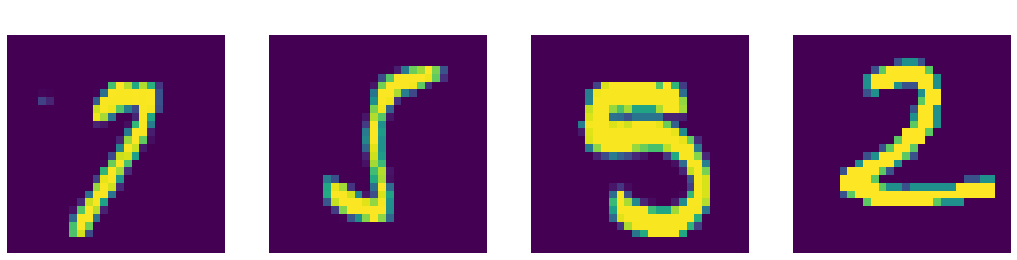

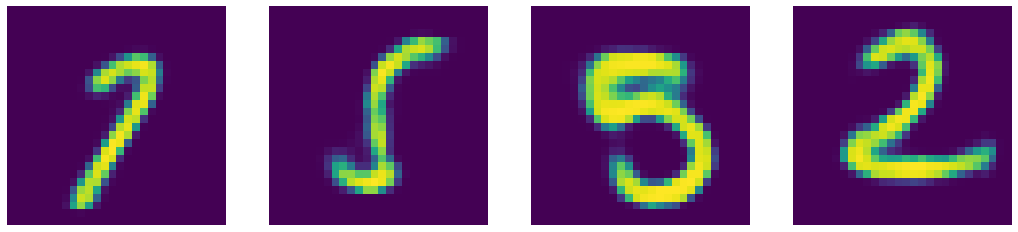

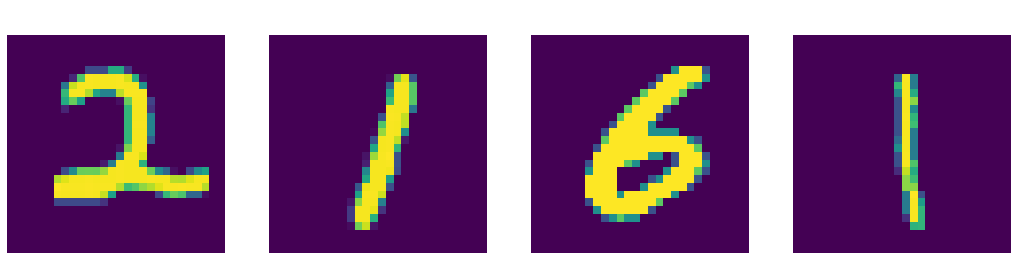

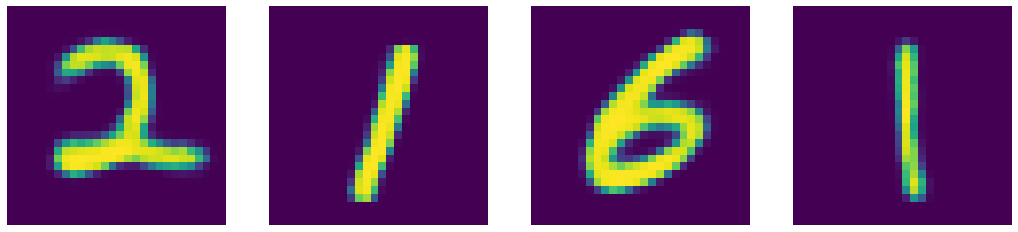

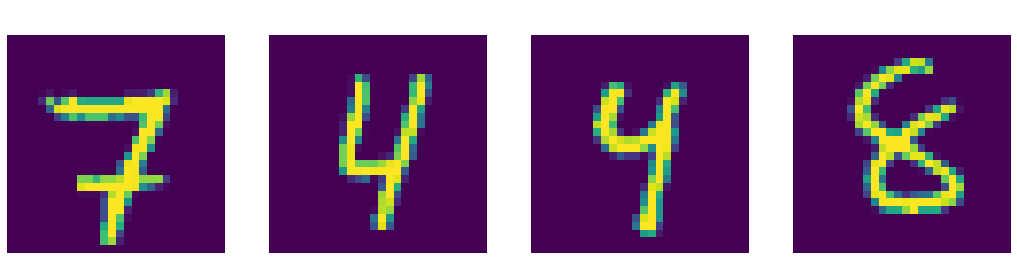

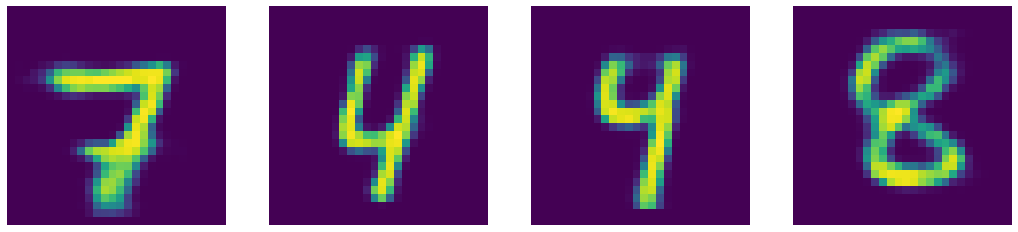

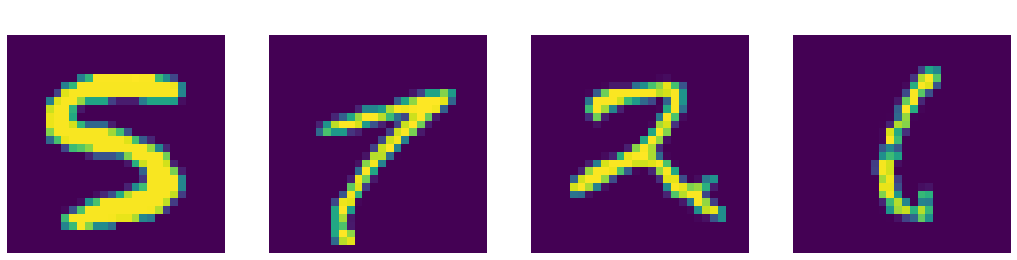

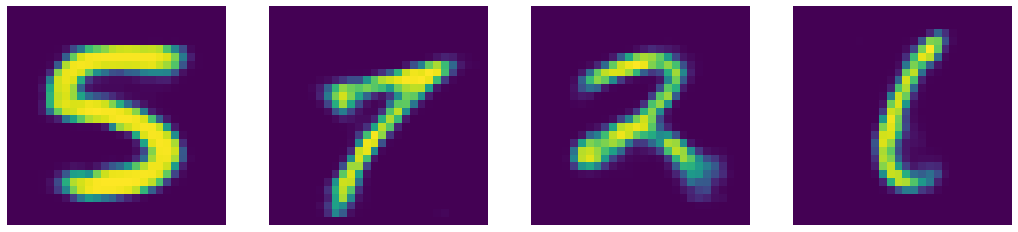

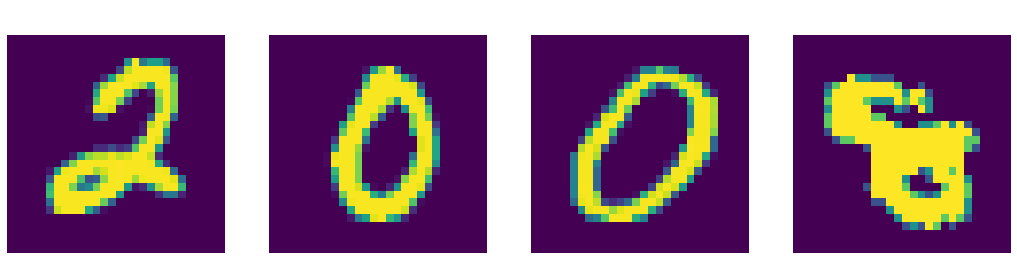

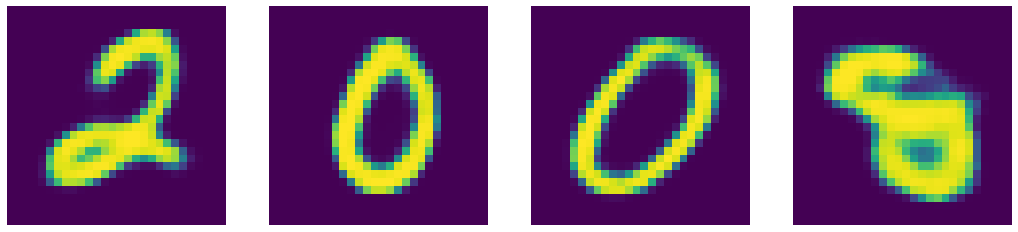

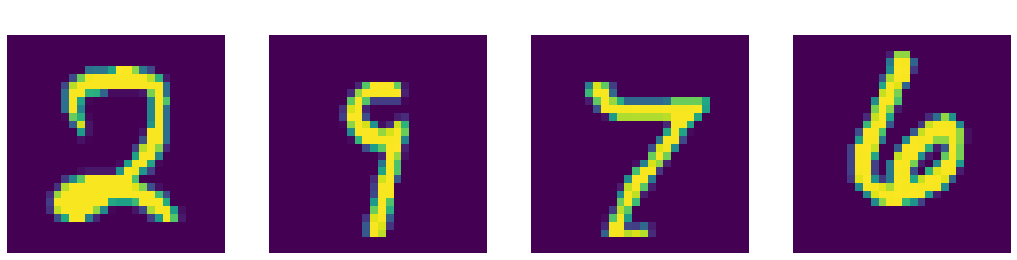

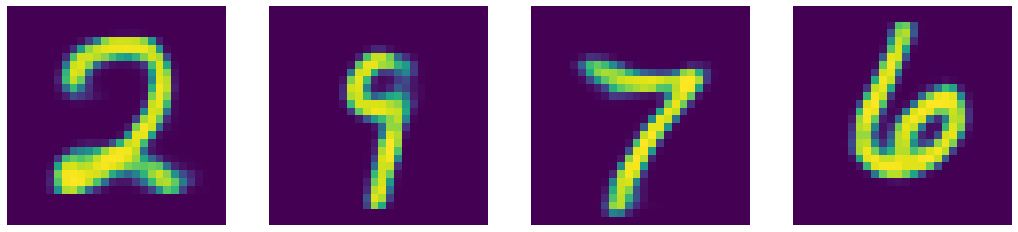

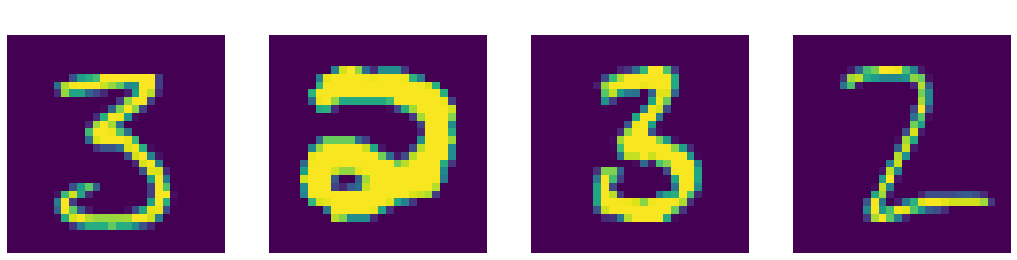

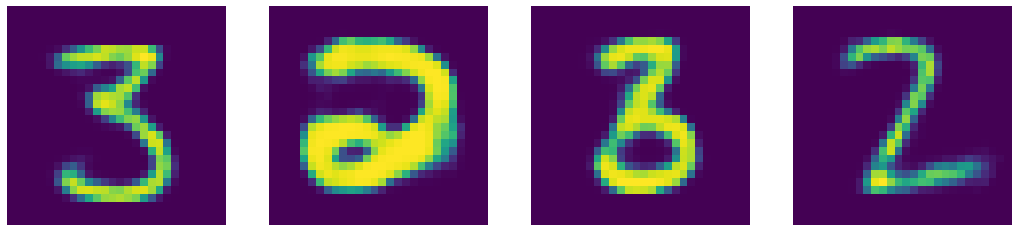

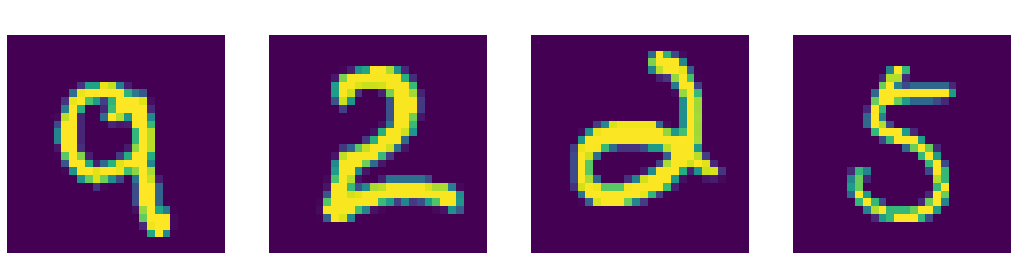

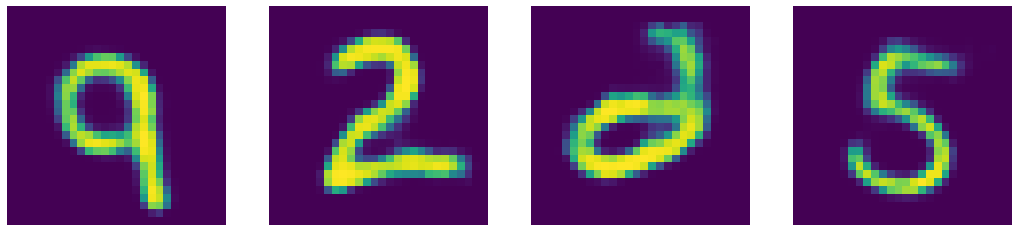

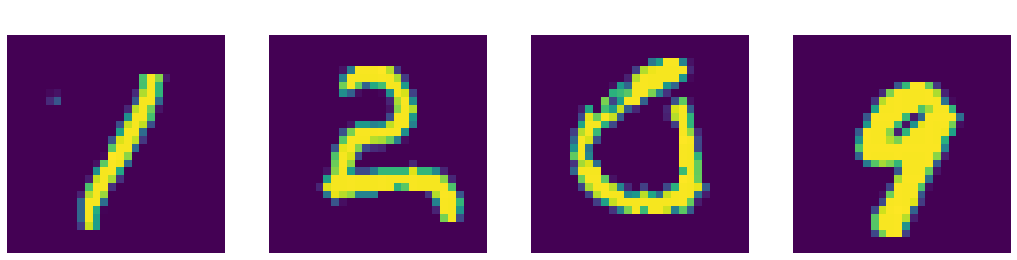

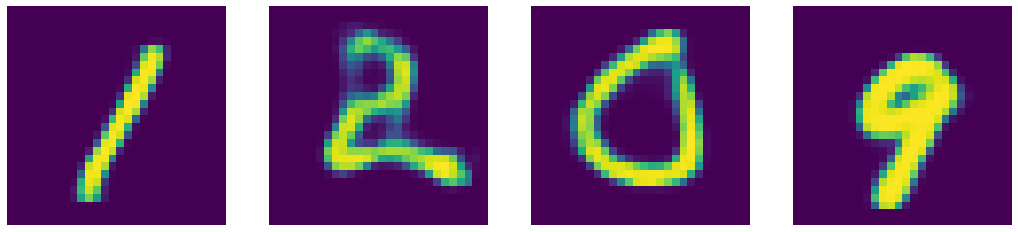

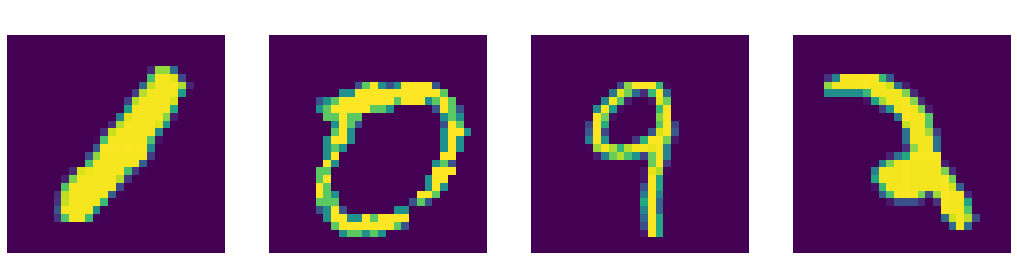

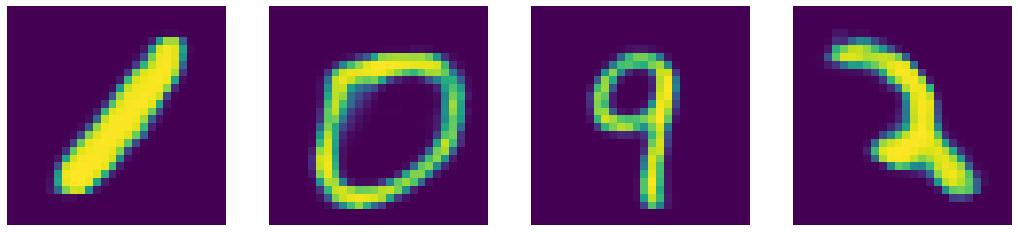

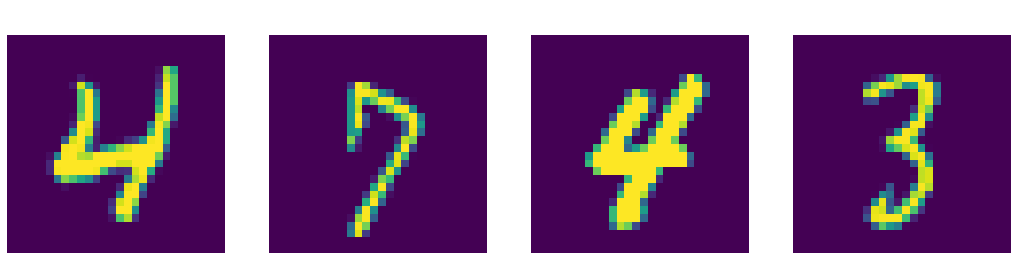

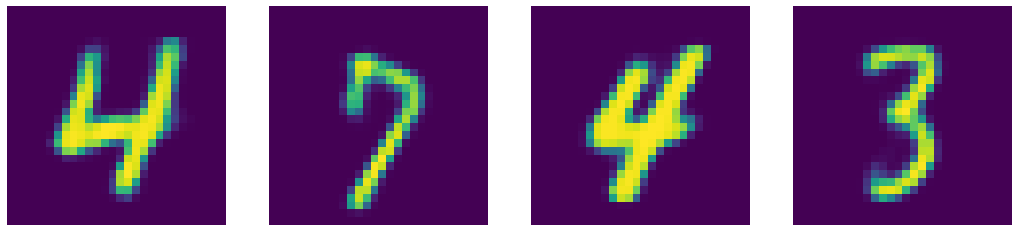

In [12]:
# Training and testing the VAE

epochs = 100
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        loss_arr.append(train_loss / len(train_loader.dataset))
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

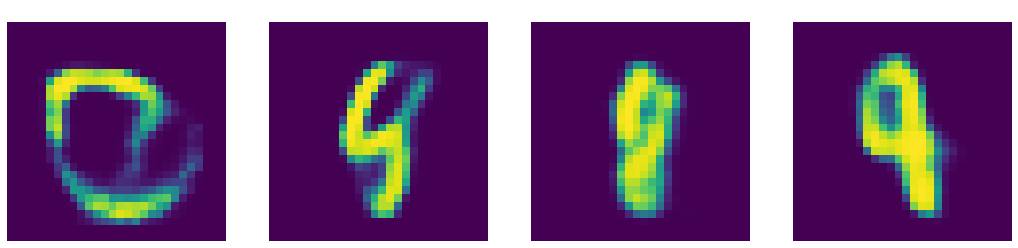

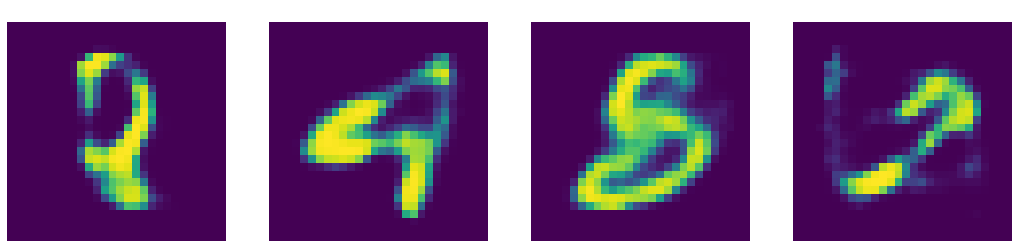

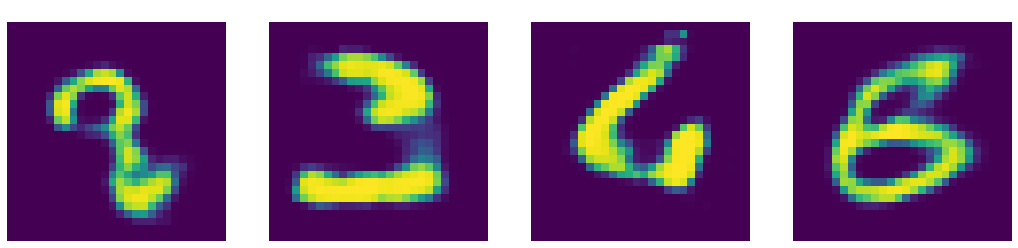

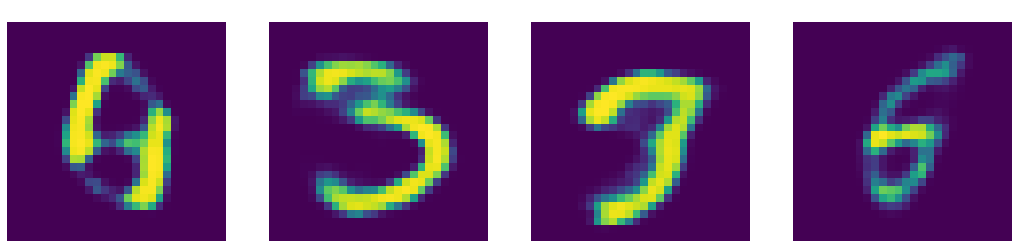

In [13]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

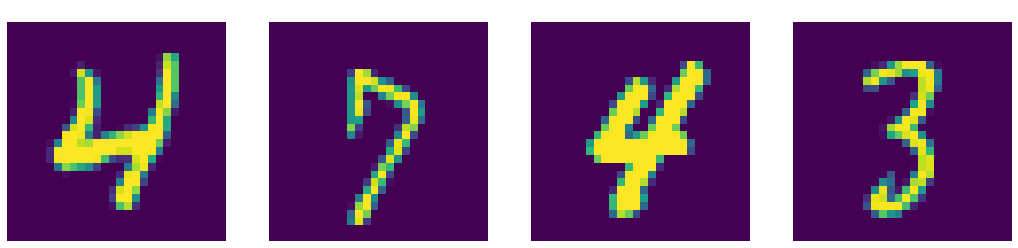

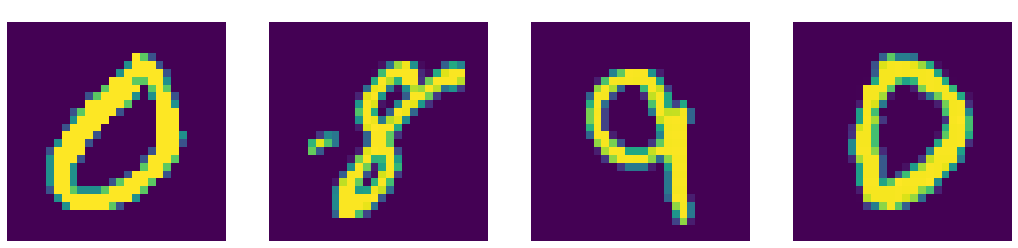

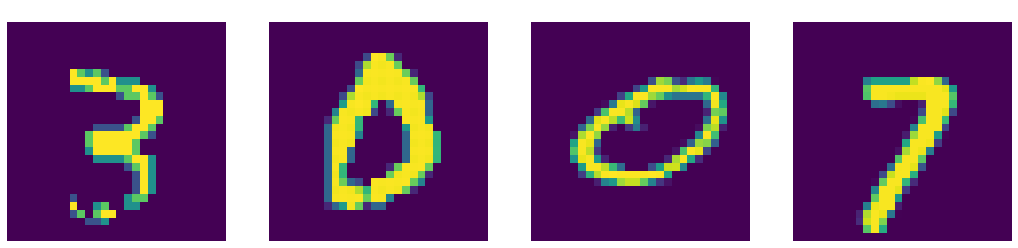

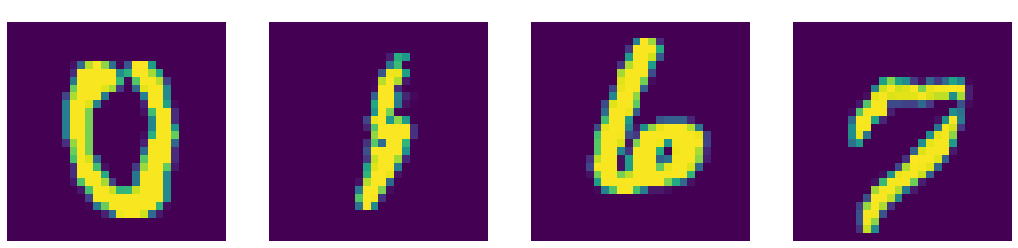

In [14]:
# Display last test batch

display_images(None, x, 4, count=True)

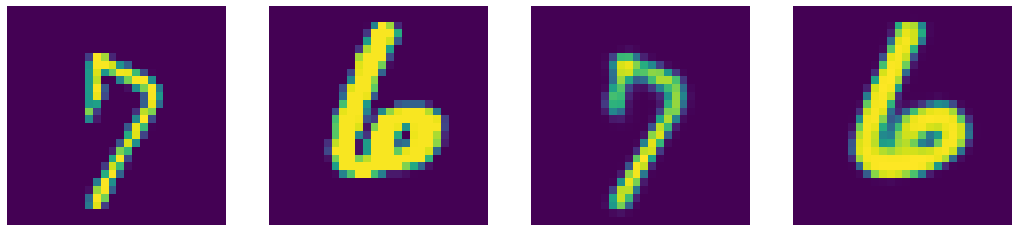

In [15]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

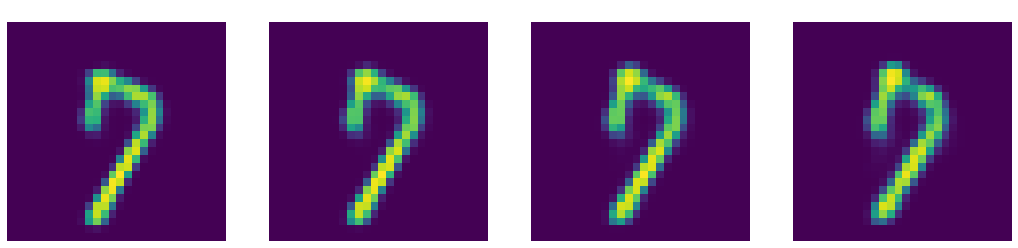

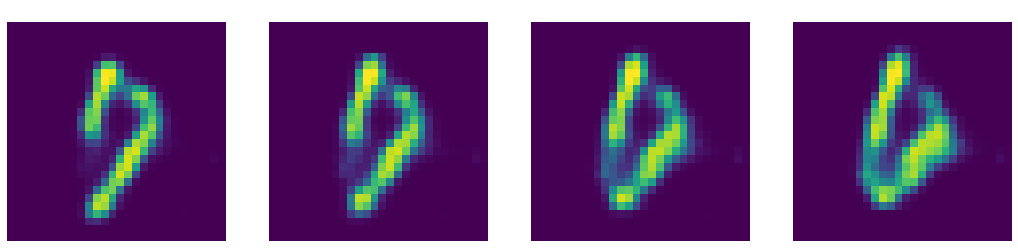

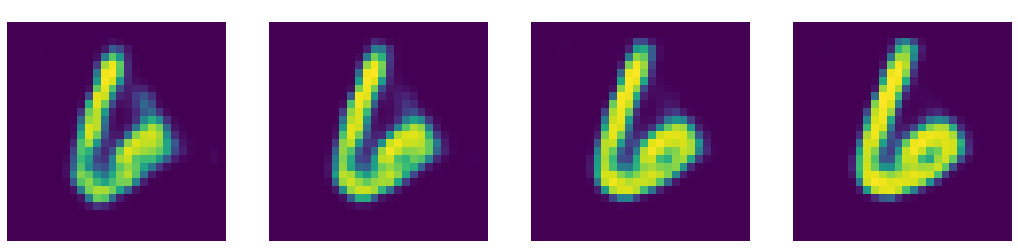

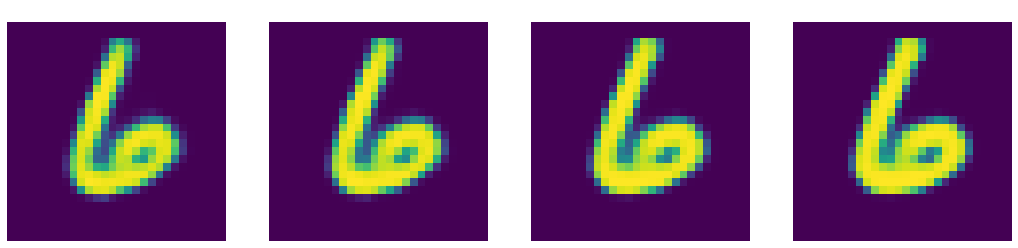

In [16]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [23]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

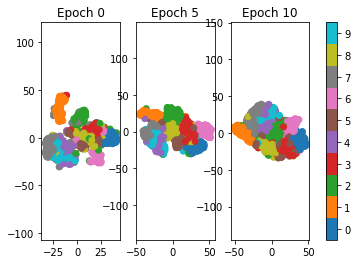

In [24]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

In [26]:
model2 = VAE().to(device)

====> Test set loss: 549.8986
====> Epoch: 1 Average loss: 549.8922
====> Test set loss: 549.8963


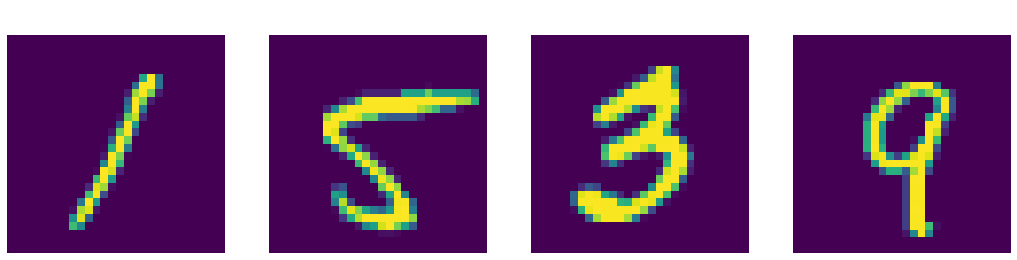

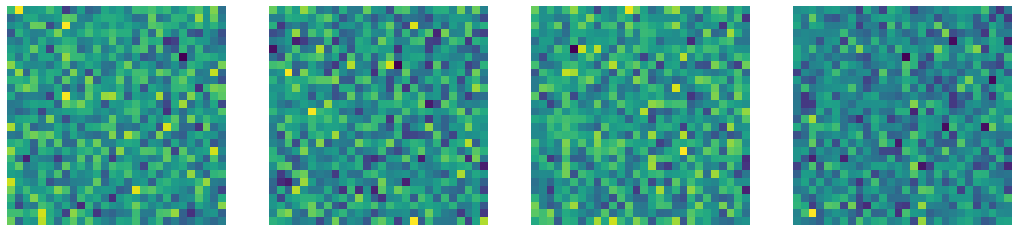

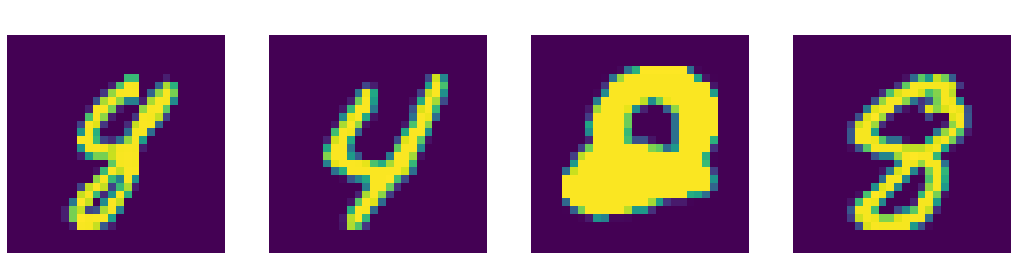

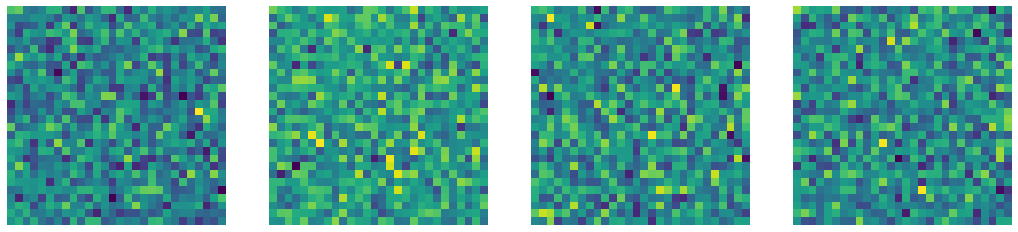

In [27]:
# Training and testing the VAE

epochs = 1
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model2.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model2(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        loss_arr.append(train_loss / len(train_loader.dataset))
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model2(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')